# DS4A / COLOMBIA 4.0 

# Topic: Consumer behavior on e-Commerce

Data science for the digital future

### Team 29

- Ximena Rios Cotazo

- Ramon Manuel Sandoval 

- Luisa Maria Carabali

- Alejandro Camargo Garcia

- Cristian Sarmiento

- Hector Melo


## E-Commerce 

This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.


## Context

This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

Taken from:[Kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_geolocation_dataset.csv )

## Topic: Consumer behavior on E-Commerce

## Research question

What aspects of consumers’ online behavior is useful for businesses to better understand  consumer trends, spending habits, variables related to the shopping, and predict demand? 

## Objectives: 

-	Data understanding and cleaning
-	Analysis and modeling 
-	Build prediction models 


## Description of the relationship between datasets:

<img src="VisualData.png">





## Requirements

In [1]:
import os
from scipy import stats
import statsmodels.formula.api as sfm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import sklearn.metrics as Metrics

In [2]:
# Ignore user warnings
import warnings
warnings.simplefilter("ignore", UserWarning)

# Load relevant packages
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab
import tensorflow as tf
import datetime

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

import plotly.graph_objects as go

%matplotlib inline
plt.style.use('ggplot')

In [3]:
ruta=os.getcwd()+'/data/'

In [4]:
customer = pd.read_csv(ruta+'olist_customers_dataset.csv', delimiter=',') 
order_items=pd.read_csv(ruta+'olist_order_items_dataset.csv', delimiter=',') 
orders=pd.read_csv(ruta+'olist_orders_dataset.csv', delimiter=',') 
products=pd.read_csv(ruta+'olist_products_dataset.csv', delimiter=',') 
order_payments=pd.read_csv(ruta+'olist_order_payments_dataset.csv', delimiter=',')
reviews=pd.read_csv(ruta+'olist_order_reviews_dataset.csv', delimiter=',')
order_items=pd.read_csv(ruta+'olist_order_items_dataset.csv', delimiter=',') 
sellers=pd.read_csv(ruta+'olist_sellers_dataset.csv', delimiter=',') 
order_reviews=pd.read_csv(ruta+'olist_order_reviews_dataset.csv', delimiter=',') 


# Exploratory Data Analisys

In this part we try to analyze which is the trend of online shopping by city.

For this analysis we generate a dataset called ```df```, which is obtained by crossing the fields: ```order_id,customer_id```, ```customer_unique_id```, ```ustomer_city,customer_state```, ```order_item_id```,  ```product_id```, ```product_category_name```   of the dataframes: ```olist_customers_dataset```, ```olist_order_items_dataset```, ```olist_orders_dataset```, ```olist_products_dataset```. For this we use pyhton's ```merge``` function:

## Load and merge Data

In [144]:
# order_id:Identificador único del pedido. customer_id: Id del cliente.customer_unique_id: Identificador único de un cliente.
df1=orders[['order_id','customer_id','order_purchase_timestamp','order_status']] 
df2=customer[['customer_id','customer_city','customer_state']] 
df=pd.merge(df1, df2, how="left", left_on="customer_id", right_on="customer_id")

In [145]:
#product_id: Identificador único del producto.order_item_id: identifica el número de artículosincluido en el mismo pedido.
df3=order_items[['order_id','order_item_id','product_id','price','freight_value']] 
df3['total_price']=df3['price'] + df3['freight_value']
df=pd.merge(df, df3, how="left", left_on="order_id", right_on="order_id")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [146]:
#product_category_name:Categoría raíz del producto, en portugués
df4=products[['product_id','product_category_name','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm']] 
df4['product_vol']=df4['product_length_cm'] * df4['product_height_cm'] * df4['product_width_cm']
df=pd.merge(df, df4, how="left", left_on="product_id", right_on="product_id")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [147]:
#review_score:puntuacion entre 1 y 5
df5=order_reviews[['order_id','review_score']] 
df=pd.merge(df, df5, how="left", left_on="order_id", right_on="order_id")

DateTime information

In [148]:
df['ano_mes']=df['order_purchase_timestamp'].str.split('-', expand=True)[0]+"-"+df['order_purchase_timestamp'].str.split('-', expand=True)[1]
df['ano_mes_dt'] = pd.to_datetime(df['ano_mes'])
df['ano_mes_dia'] = df['order_purchase_timestamp'].str.split(' ', expand=True)[0]
df['ano_mes_dia_dt'] = pd.to_datetime(df['ano_mes_dia'])
df['fecha'] = pd.to_datetime(df['order_purchase_timestamp'])
df['mes']= df['fecha'].dt.month
df['year']=df['fecha'].dt.year
df.ano_mes = df.ano_mes.astype('category')
df['month_codes']= df.ano_mes.cat.codes

## Regional and estates information

The states are by [ISO code](https://es.wikipedia.org/wiki/Anexo:Estados_de_Brasil), we create an dictionary (```estados```) with these codes and the corresponding name, and another dictionary (```regiones```) with the regions for each state, then we add two columns to the dataframe, one with the name of the state and the other with the region, we do this for a more comfortable viewing.

In [149]:
estados= {'AC':'Acre', 'AL':'Alagoas', 'AM':'Amazonas', 'AP':'Amapá', 'BA':'Bahía', 'CE':'Ceará',
          'DF':'Distrito Federal', 'ES':'Espírito Santo', 'GO':'Goiás', 'MA':'Maranhão', 'MG':'Minas Gerais',
          'MS':'Mato Grosso del Sur', 'MT':'Mato Grosso', 'PA':'Pará', 'PB':'Paraíba', 'PE':'Pernambuco',
          'PI':'Piauí', 'PR':'Paraná', 'RJ':'Río de Janeiro', 'RN':'Río Grande del Norte', 'RO':'Rondonia',
          'RR':'Roraima', 'RS':'Río Grande del Sur', 'SC':'Santa Catarina', 'SE':'Sergipe', 'SP':'São Paulo', 'TO':'Tocantins'}
df['name_state']=df['customer_state']
for i in range(len(estados)):
    df["name_state"]=df["name_state"].str.replace(list(estados.keys())[i],list(estados.values())[i])

In [150]:
region = ["Norte","Sur","Sudeste","Nordeste","CentroOeste"]
regiones= {'AC':'Norte', 'AL':'Nordeste', 'AM':'Norte', 'AP':'Norte', 'BA':'Nordeste',
           'CE':'Nordeste', 'DF':'CentroOeste', 'ES':'Sudeste', 'GO':'CentroOeste',
           'MA':'Nordeste', 'MG':'Sudeste', 'MS':'CentroOeste', 'MT':'CentroOeste',
           'PA':'Norte', 'PB':'Nordeste', 'PE':'Nordeste', 'PI':'Nordeste', 'PR':'Sur',
           'RJ':'Sudeste', 'RN':'Nordeste', 'RO':'Norte', 'RR':'Norte', 'RS':'Sur',
           'SC':'Sur', 'SE':'Nordeste', 'SP':'Sudeste', 'TO':'Norte'}
df['regions']=df['customer_state']
for i in range(len(estados)):
    df["regions"]=df["regions"].str.replace(list(regiones.keys())[i],list(regiones.values())[i])

In [151]:
df.regions  = df.regions .astype(pd.api.types.CategoricalDtype(categories=["Norte","Sur","Sudeste","Nordeste","CentroOeste"]))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114100 entries, 0 to 114099
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  114100 non-null  object        
 1   customer_id               114100 non-null  object        
 2   order_purchase_timestamp  114100 non-null  object        
 3   order_status              114100 non-null  object        
 4   customer_city             114100 non-null  object        
 5   customer_state            114100 non-null  object        
 6   order_item_id             113322 non-null  float64       
 7   product_id                113322 non-null  object        
 8   price                     113322 non-null  float64       
 9   freight_value             113322 non-null  float64       
 10  total_price               113322 non-null  float64       
 11  product_category_name     111710 non-null  object        
 12  pr

# Cleaning

In [15]:
prices= df.groupby(['ano_mes_dia_dt']).agg({'total_price': ['sum']}) 
prices.columns=prices.columns.droplevel(1)

Because there are dates with 0 sales in the beguining and the end, we drop this data

In [16]:
date_time_str = '2017-01-10'
prices=prices[(prices.index> pd.to_datetime(date_time_str))]
date_time_str = '2018-08-22'
prices=prices[(prices.index< pd.to_datetime(date_time_str))]

# Data Analisys

To analize the pruchases, we gruop the purshaces for day to see the trends

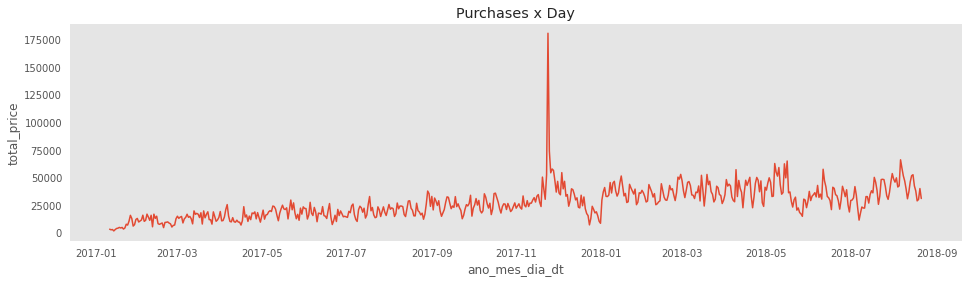

In [17]:
plt.figure(figsize=(16, 4))
ax=sns.lineplot(x=prices.index,y='total_price',data=prices);
ax.set_title('Purchases x Day')
ax.grid()

If we see the graph daily we can see how and the end of November 2017 the number of orders increased significative for some days and later decreasing, we are evaluating the event that took place those days to see the variability of the values.

In [18]:
#Adding the days to the Data frame
orders_by_date = pd.merge(left = orders , right = order_payments , how='left', left_on='order_id', right_on='order_id')
orders_by_date = orders_by_date.drop(['order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date','payment_sequential', 'payment_type', 'payment_installments'], axis=1)
orders_by_date = orders_by_date.dropna()
orders_by_date = orders_by_date.reset_index(drop=True)
orders_by_date['order_purchase_timestamp'] = pd.to_datetime(orders_by_date['order_purchase_timestamp'])

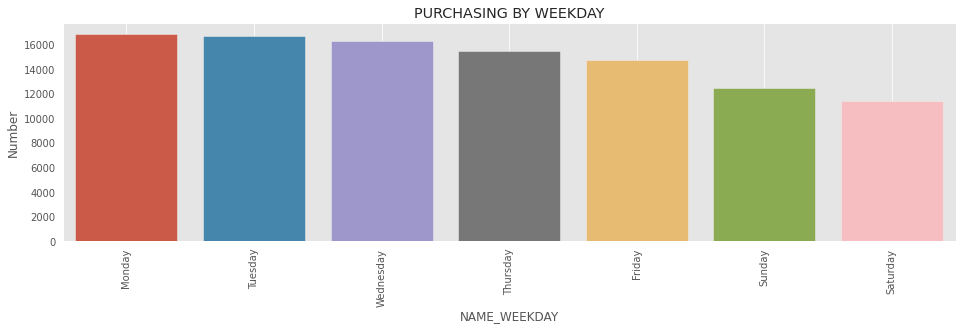

In [19]:
orders_by_date["NAME_WEEKDAY"] = orders_by_date['order_purchase_timestamp'].dt.day_name()
plt.figure(figsize=(16, 4))
aux= orders_by_date.groupby("NAME_WEEKDAY").size().to_frame().rename(columns={0:'Number'}).sort_values("NAME_WEEKDAY", ascending=False).sort_values('Number', ascending=False).reset_index()
listaC=list(aux["NAME_WEEKDAY"])
ax=sns.barplot(x="NAME_WEEKDAY",y='Number',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('PURCHASING BY WEEKDAY')
ax.grid()

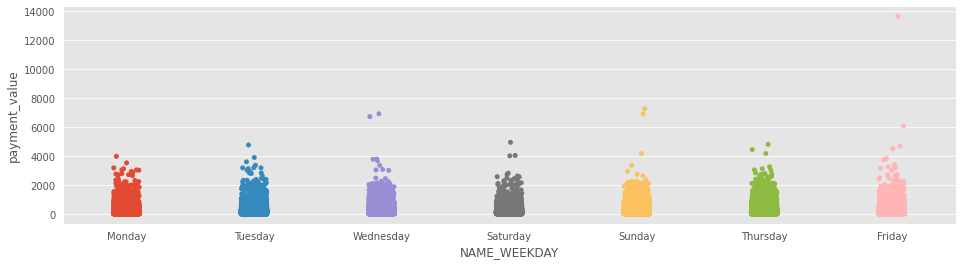

In [20]:
plt.figure(figsize=(16, 4))
ax = sns.stripplot(x="NAME_WEEKDAY", y="payment_value", data = orders_by_date)
plt.ylabel('payment_value')
plt.show()

As shown in the graph, the sales values are more or less grouped below 3000, only a few values exceeded 3000 and are located below 6000, another four sales above 8000 and a single one per ma of 13000 reais.

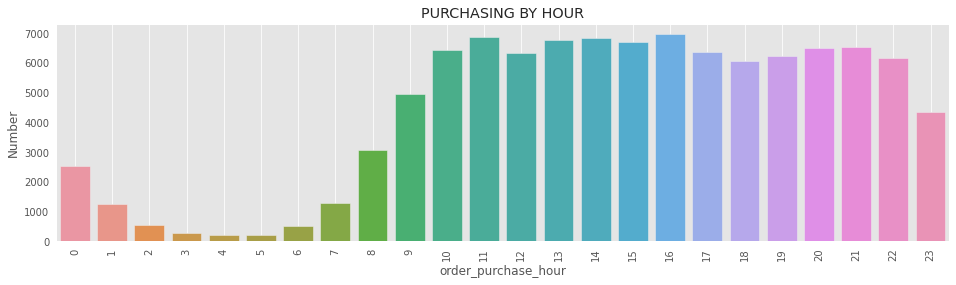

In [21]:
#Adding the hours to the Data frame
orders_by_date["order_purchase_hour"] = orders_by_date['order_purchase_timestamp'].dt.hour
plt.figure(figsize=(16, 4))
aux= orders_by_date.groupby("order_purchase_hour").size().to_frame().rename(columns={0:'Number'}).sort_values("order_purchase_hour", ascending=False).sort_values('Number', ascending=False).reset_index()
listaC=list(aux["order_purchase_hour"])
ax=sns.barplot(x="order_purchase_hour",y='Number',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('PURCHASING BY HOUR')
ax.grid()

Here in the Stripplox we can see a better look of how the purchasings are accumulated over the hours with more of the values around 3000 and less over the 3000 and 9000 and just one value below the 14000.

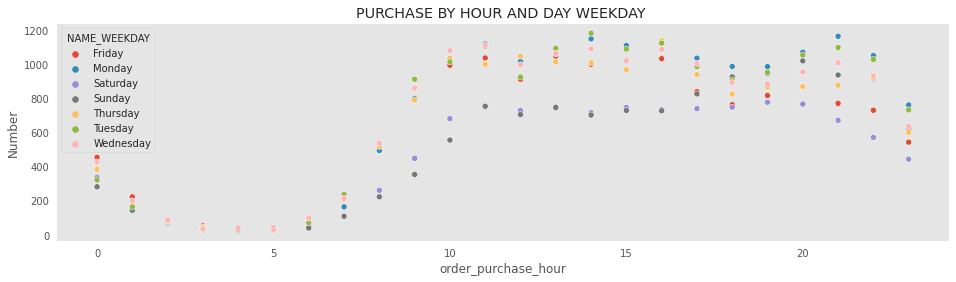

In [22]:
plt.figure(figsize=(16, 4))
aux = orders_by_date[["order_purchase_hour","NAME_WEEKDAY"]]
aux = aux.groupby(["order_purchase_hour","NAME_WEEKDAY"]).size().to_frame().rename(columns={0:'Number'}).reset_index()
#aux = aux.sort_values('Number', ascending=False)
#aux=aux[:50]
ax=sns.scatterplot(x="order_purchase_hour", y='Number', hue="NAME_WEEKDAY", data=aux)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('PURCHASE BY HOUR AND DAY WEEKDAY ')
ax.grid()


## Total product sales by region

The dataframe has 74 product categories, we generate a graph with the amount of products sold by region and we organize it in descending order.

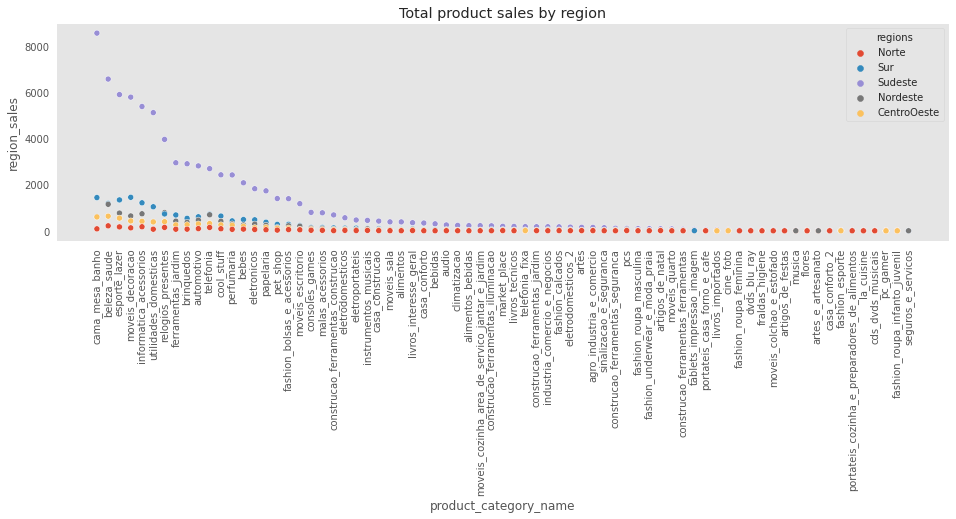

In [23]:
plt.figure(figsize=(16, 4))
aux=df[["product_category_name","regions"]]
aux=aux.groupby(["product_category_name","regions"]).size().to_frame().rename(columns={0:'region_sales'}).sort_values('region_sales', ascending=False).reset_index()
#aux=aux[:50]
#ax=sns.lineplot(x='product_category_name', y='region_sales', hue='regions', data=aux)
ax=sns.scatterplot(x='product_category_name', y='region_sales', hue='regions', data=aux)
plt.xticks(rotation=90)
ax.set_title('Total product sales by region')
ax.grid()

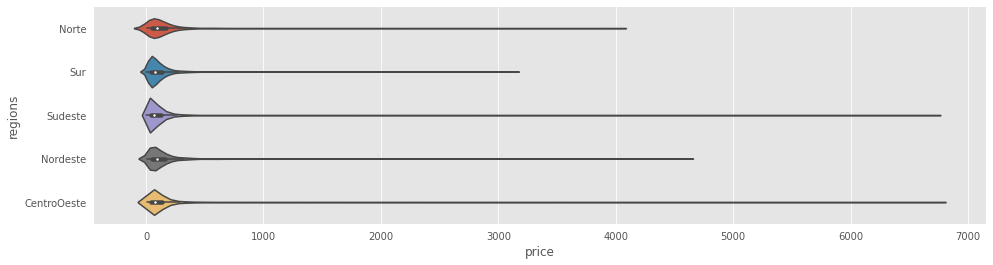

In [24]:
plt.figure(figsize=(16, 4))
sns.violinplot(x='price',y='regions', data=df )
plt.show()

## Top Products sold

We generate a graph with the amount of products sold by category and organize it descendingly.

The dataframe has  74  categories of products


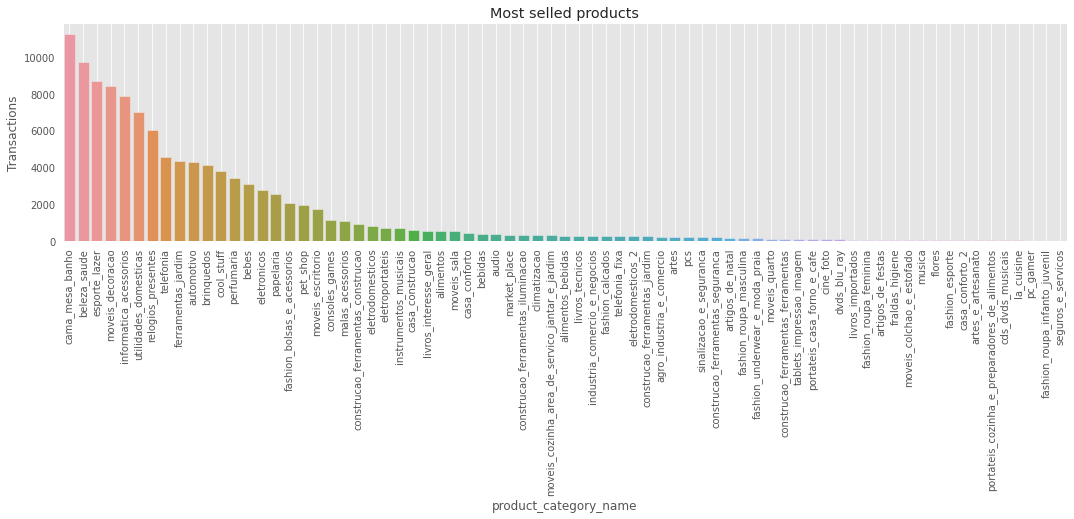

In [25]:
plt.figure(figsize=(18, 4))
aux=df.groupby('product_category_name').size().to_frame().rename(columns={0:'Transactions'}).sort_values('Transactions', ascending=False).head(74).reset_index()
listaP=list(aux["product_category_name"])
ax=sns.barplot(x='product_category_name',y='Transactions',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Most selled products')
ax.grid()
print("The dataframe has ",len(df['product_category_name'].unique())," categories of products")

Regarding the best-selling products, the following categories have the highest amount of sales:

|Product Category   |Number of purchases |
|---|---|
|Cama_mesa_banho |11.823 |
|beleza_saude |9.972|
|esporte_lazer | 8.945|
|moveis_decoracao |8744| 
|informatica_acessorios |8082|
|utilidades_domesticas |7355|

# Cities with the highest number of sales

The dataframe has 4119 cities, we take the 50 cities that have the most registered sales, and we generate a graph with the number of sales per city, organized in descending order.

We have 4119 cities, the 50 that register the highest number of sales are shown


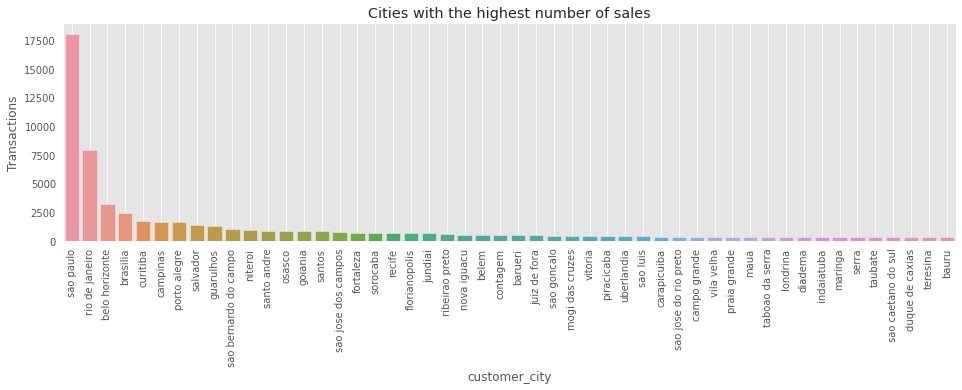

In [26]:
plt.figure(figsize=(16, 4))
aux=df.groupby('customer_city').size().to_frame().rename(columns={0:'Transactions'}).sort_values('Transactions', ascending=False).head(50).reset_index()
listaC=list(aux["customer_city"])
ax=sns.barplot(x='customer_city',y='Transactions',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Cities with the highest number of sales')
ax.grid()
print("We have", len(df["customer_city"].unique()),"cities, the 50 that register the highest number of sales are shown")

# Best-selling products by city

The dataframe has 74 product categories, we generate a graph with the amount of products sold by city and we organize it in descending order, we take the 10 cities that register the highest number of sales.

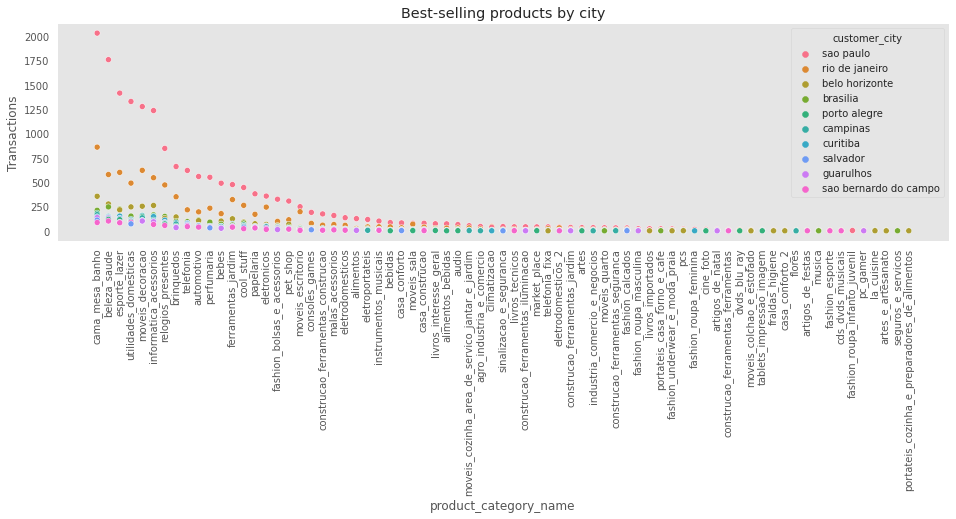

In [27]:
listaC2=listaC[:10]
plt.figure(figsize=(16, 4))
aux=df[(df["customer_city"].isin(listaC2))][["product_category_name","customer_city"]]
aux=aux.groupby(["product_category_name","customer_city"]).size().to_frame().rename(columns={0:'Transactions'}).reset_index()
aux=aux.sort_values('Transactions', ascending=False)
#aux=aux[:50]
#ax=sns.lineplot(x='product_category_name', y='Number de transaciones', hue='customer_city', data=aux)
ax=sns.scatterplot(x='product_category_name', y='Transactions', hue='customer_city', data=aux)
plt.xticks(rotation=90)
ax.set_title('Best-selling products by city')
ax.grid()

# Best-selling products by state

The dataframe has 74 product categories, we generate a graph with the amount of products sold by state and we organize it in descending order.

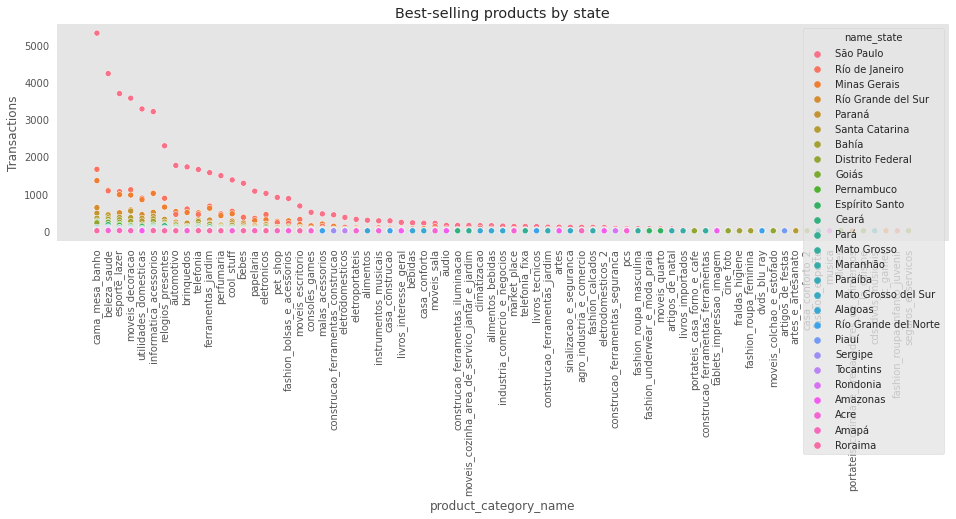

In [28]:
plt.figure(figsize=(16, 4))
aux=df[["product_category_name","name_state"]]
aux=aux.groupby(["product_category_name","name_state"]).size().to_frame().rename(columns={0:'Transactions'}).reset_index()
aux=aux.sort_values('Transactions', ascending=False)
ax=sns.scatterplot(x='product_category_name', y='Transactions', hue='name_state', data=aux)
plt.xticks(rotation=90)
ax.set_title('Best-selling products by state')
ax.grid()

# Review score by product

The dataframe has 74 product categories, we generate a graph with the amount of stars per product in descending order.

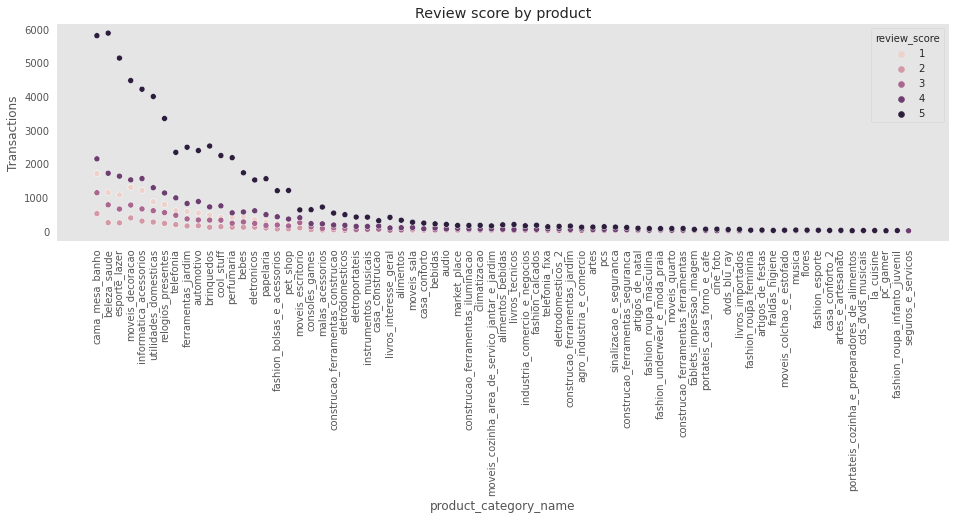

In [29]:
plt.figure(figsize=(16, 4))
aux=df[["product_category_name","review_score"]]
aux=aux.groupby(["product_category_name","review_score"]).size().to_frame().rename(columns={0:'Transactions'}).reset_index()
aux.product_category_name  = aux.product_category_name .astype(pd.api.types.CategoricalDtype(categories=listaP, ordered = True))
ax=sns.scatterplot(x='product_category_name',y='Transactions',hue='review_score',data=aux);
plt.xticks(rotation=90);
ax.set_title('Review score by product')
ax.grid()

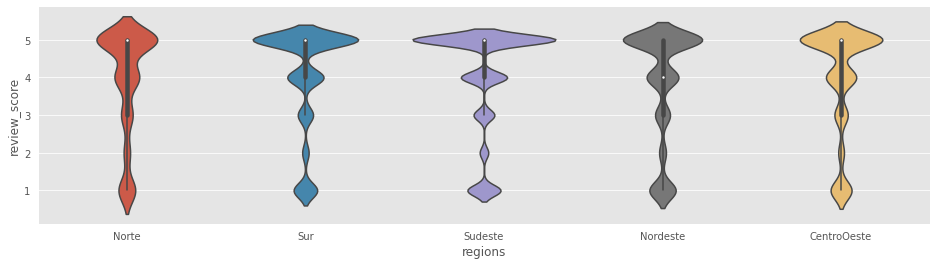

In [30]:
plt.figure(figsize=(16, 4))
sns.violinplot(x='regions',y='review_score', data=df )
plt.show()

# Best-selling products by month


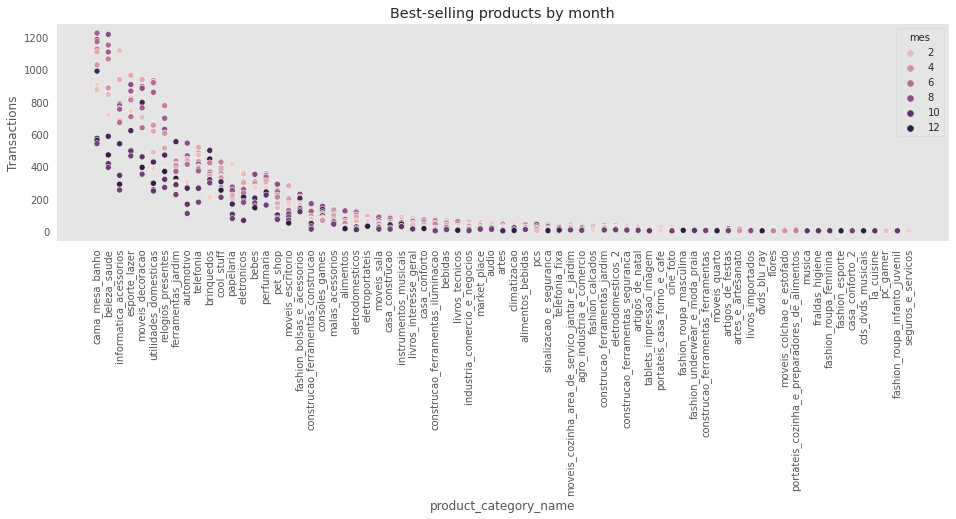

In [31]:
plt.figure(figsize=(16, 4))
aux=df[["product_category_name","mes"]]
aux2=aux[(aux["mes"]>0)]
aux2=aux2.groupby(["product_category_name","mes"]).size().to_frame().rename(columns={0:'Transactions'}).sort_values('Transactions', ascending=False).reset_index()
#aux2=aux2[(aux2["Transactions"]>10)]
ax=sns.scatterplot(x='product_category_name', y='Transactions',hue="mes", data=aux2)
plt.xticks(rotation=90)
ax.set_title('Best-selling products by month')
ax.grid()

## Prices per product

Regarding the prices for the different product categories, we find that the most expensive products are related to the categories of Household utilities, Computers, Arts and electrical appliances. Within these, the highest price range refers to computers

<AxesSubplot:xlabel='price', ylabel='product_category_name'>

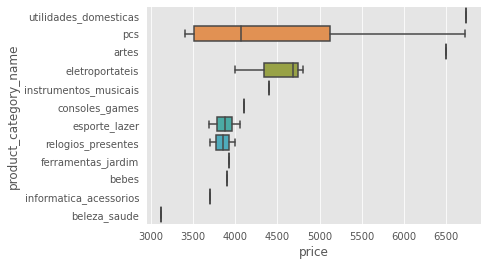

In [32]:
order_product=pd.merge(products, order_items)
top_products= order_product.sort_values(['price'],ascending=False).head(20)
sns.boxplot(y=top_products['product_category_name'], x=top_products["price"])

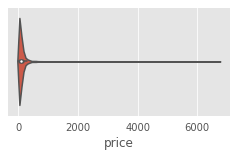

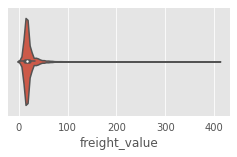

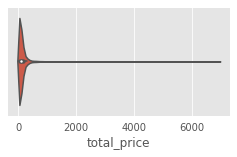

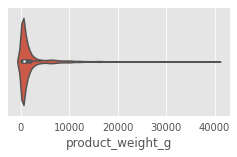

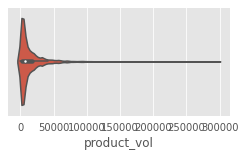

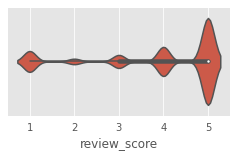

In [33]:
variables=['price','freight_value','total_price','product_weight_g','product_vol','review_score']

for i,var in enumerate(variables):
    plt.figure(figsize=(4, 2))
    sns.violinplot(x=var, data=df )
    plt.show

# Difference between Delivered Time and Delivered Estimated Time vs Reviews

In [34]:
a=pd.merge(order_items, orders, on=['order_id'])
merged_df=pd.merge(a, products, on=['product_id'])

In [35]:
delivered_time = pd.to_datetime(merged_df.order_delivered_customer_date)
estimated_time = pd.to_datetime(merged_df.order_estimated_delivery_date)

merged_df["late_delivery"] = delivered_time - estimated_time
merged_df["late_delivery"]=merged_df["late_delivery"]/np.timedelta64(1,"D")

# Late Deliveries

In [36]:
delivered_time = pd.to_datetime(merged_df.order_delivered_customer_date)
approved_time = pd.to_datetime(merged_df.order_approved_at)
merged_df["delivery_time"] = delivered_time - approved_time
merged_df["delivery_time"] = merged_df["delivery_time"]/np.timedelta64(1,"D")

In [37]:
late_deliveries_df = merged_df[merged_df.late_delivery > 0]
late_deliveries_df[["product_category_name", "order_delivered_customer_date", "order_estimated_delivery_date", "late_delivery"]].head(10)

,product_category_name,order_delivered_customer_date,order_estimated_delivery_date,late_delivery
5,cool_stuff,2017-08-31 20:19:52,2017-08-24 00:00:00,7.847130
16,ferramentas_jardim,2018-04-02 22:32:10,2018-03-23 00:00:00,10.939005
29,utilidades_domesticas,2017-07-10 11:46:40,2017-07-10 00:00:00,0.490741
36,beleza_saude,2018-03-29 18:17:31,2018-03-29 00:00:00,0.762164
68,beleza_saude,2018-05-23 17:51:15,2018-05-16 00:00:00,7.743924
69,beleza_saude,2018-05-23 17:51:15,2018-05-16 00:00:00,7.743924
71,beleza_saude,2018-02-24 16:26:53,2018-02-21 00:00:00,3.685336
97,fashion_bolsas_e_acessorios,2018-08-07 13:56:52,2018-08-07 00:00:00,0.581157
120,cama_mesa_banho,2017-09-04 13:34:13,2017-08-31 00:00:00,4.565428
121,cama_mesa_banho,2018-03-29 23:42:46,2018-03-16 00:00:00,13.988032


# Difference between Delivered Time and Delivered Estimated Time vs Reviews

In [38]:
delivered_time = pd.to_datetime(merged_df.order_delivered_customer_date)
approved_time = pd.to_datetime(merged_df.order_approved_at)
merged_df["delivery_time"] = delivered_time - approved_time
merged_df["delivery_time"] = merged_df["delivery_time"]/np.timedelta64(1,"D")

In [39]:
delivery_time_df = merged_df[merged_df.delivery_time > 0]
delivery_time_df[["product_category_name", "order_delivered_customer_date", "order_estimated_delivery_date", "late_delivery"]].head(10)

,product_category_name,order_delivered_customer_date,order_estimated_delivery_date,late_delivery
0,cool_stuff,2017-09-20 23:43:48,2017-09-29 00:00:00,-8.011250
1,cool_stuff,2017-07-13 20:39:29,2017-07-26 00:00:00,-12.139248
2,cool_stuff,2018-06-04 18:34:26,2018-06-07 00:00:00,-2.226088
3,cool_stuff,2017-08-09 21:26:33,2017-08-25 00:00:00,-15.106563
4,cool_stuff,2017-08-24 20:04:21,2017-09-01 00:00:00,-7.163646
5,cool_stuff,2017-08-31 20:19:52,2017-08-24 00:00:00,7.847130
6,cool_stuff,2018-03-28 21:57:44,2018-04-12 00:00:00,-14.084907
7,cool_stuff,2017-08-14 18:13:03,2017-09-06 00:00:00,-22.240938
8,cool_stuff,2017-06-26 13:52:03,2017-07-06 00:00:00,-9.422187
9,pet_shop,2017-05-12 16:04:24,2017-05-15 00:00:00,-2.330278


In [40]:
orders1 = orders.copy()
orders1 = orders1[['order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date']]
orders1['order_delivered_customer_date'] = pd.to_datetime(orders1['order_delivered_customer_date'])
orders1['order_estimated_delivery_date'] = pd.to_datetime(orders1['order_estimated_delivery_date'])
orders1['Estimated_Delivered'] = orders1['order_delivered_customer_date']-orders1['order_estimated_delivery_date']
orders1['Estimated_Delivered'] = orders1['Estimated_Delivered'].dt.days
orders1.head()

,order_id,order_delivered_customer_date,order_estimated_delivery_date,Estimated_Delivered
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-10 21:25:13,2017-10-18,-8.0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-08-07 15:27:45,2018-08-13,-6.0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-17 18:06:29,2018-09-04,-18.0
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-12-02 00:28:42,2017-12-15,-13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-16 18:17:02,2018-02-26,-10.0


In [41]:
orders_reviews = pd.merge(orders1, reviews, on="order_id", how="left")
orders_reviews = orders_reviews[['order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'Estimated_Delivered', 'review_score']]
orders_reviews['Puntuality'] = np.where(orders_reviews['Estimated_Delivered'] <= 0, "Punctual", "Unpunctual")
orders_reviews.head()

,order_id,order_delivered_customer_date,order_estimated_delivery_date,Estimated_Delivered,review_score,Puntuality
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-10 21:25:13,2017-10-18,-8.0,4,Punctual
1,53cdb2fc8bc7dce0b6741e2150273451,2018-08-07 15:27:45,2018-08-13,-6.0,4,Punctual
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-17 18:06:29,2018-09-04,-18.0,5,Punctual
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-12-02 00:28:42,2017-12-15,-13.0,5,Punctual
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-16 18:17:02,2018-02-26,-10.0,5,Punctual


Now, we make cathegorical variables by the reviews scores as punctual or unpunctual by the difference between Estimated Delivery and Real Delivery. When this delta is negative or zero, we classify it as "Punctual" because the company accomplish his terms of service, else the variable takes the "Unpunctual" value

In [42]:
x_review_punctual = pd.crosstab(orders_reviews['review_score'], orders_reviews['Puntuality'])
x_review_punctual

Puntuality,Punctual,Unpunctual
review_score,,
1,6205,5653
2,2442,793
3,7345,942
4,18382,818
5,56076,1344


Here we can see the count by Puntuality and the review scores. Scannig the table, we realize that there is a inverse correlation between the score of the review and the puntuality of the delivery. This relationship is inverse. When the company is punctual in his delivery, then the costumer tends to make a good review with a good score and viceversa.

In [43]:
x_review_punctual_p = pd.crosstab(orders_reviews['review_score'], orders_reviews['Puntuality']).apply(lambda r: r*100/len(orders_reviews), axis=1)
x_review_punctual_p.reset_index
x_review_punctual_p

Puntuality,Punctual,Unpunctual
review_score,,
1,6.205,5.653
2,2.442,0.793
3,7.345,0.942
4,18.382,0.818
5,56.076,1.344


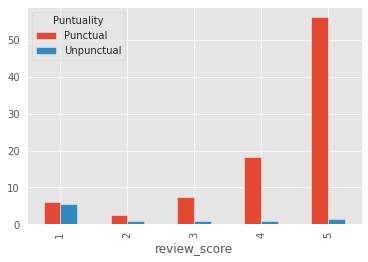

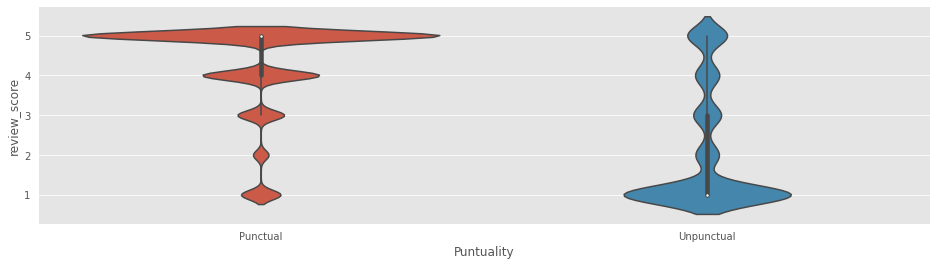

In [44]:
x_review_punctual_p.plot(kind="bar")
plt.figure(figsize=(16, 4))
sns.violinplot(x='Puntuality',y='review_score', data=orders_reviews )
plt.show()

# Prediction Models

# Linear Regression 

# 1. Sales of a product per month

### Data Exploration

We generate a graphic of the sells per month by a product

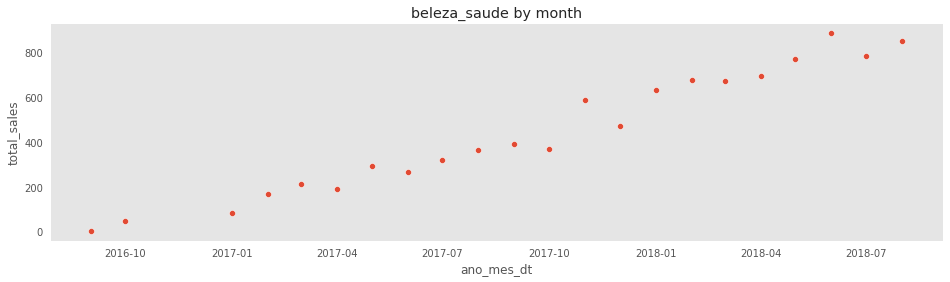

In [152]:
item=2
plt.figure(figsize=(16, 4))

aux=df[["product_category_name","ano_mes_dt","month_codes"]]
aux=aux.groupby(["product_category_name","ano_mes_dt","month_codes"]).size().to_frame().rename(columns={0:'total_sales'}).sort_values('total_sales', ascending=False).reset_index()
listaP=list(aux["product_category_name"])
aux=aux[(aux["product_category_name"]==listaP[item])]
ax=sns.scatterplot(x='ano_mes_dt', y='total_sales', data=aux)
#plt.xticks(rotation=90)
ax.set_title(listaP[item]+' by month')
ax.grid()

### Correlación

Medimos la relación lineal entre las variables, calculamos la matriz de correlacion para determinar la influencia de las variables :

In [153]:
corr_mat  = aux[['total_sales','month_codes']].corr()
corr_mat

,total_sales,month_codes
total_sales,1.000000,0.984842
month_codes,0.984842,1.000000


### Linear regression of a category of health and beauty by monyh

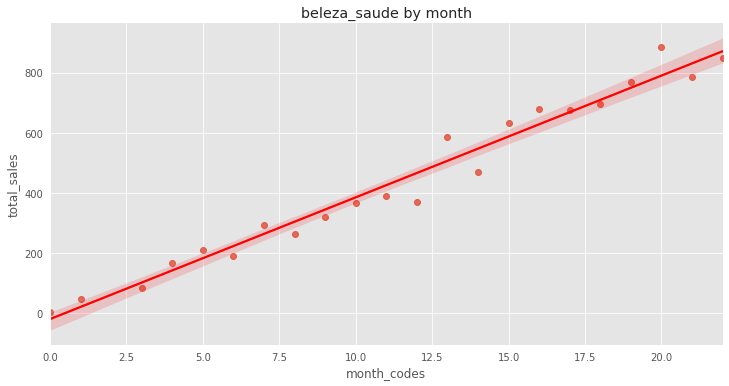

In [154]:
# relación lineal entre las ventas totales y el mes
sns.lmplot(x='month_codes',y='total_sales',data=aux,line_kws = {'color': "red"} ,aspect= 2)
plt.title(listaP[item]+' by month');

### Model

In [155]:
formula = 'total_sales~month_codes'
model   = sfm.ols(formula = formula, data = aux).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_sales   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     644.8
Date:                Sat, 19 Dec 2020   Prob (F-statistic):           1.09e-16
Time:                        19:51:50   Log-Likelihood:                -115.60
No. Observations:                  22   AIC:                             235.2
Df Residuals:                      20   BIC:                             237.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -19.9722     20.941     -0.954      

In [156]:
# predict
X = sm.add_constant(aux["month_codes"][:1])
model.predict(X)

2    790.178276
dtype: float64

# Conclusion

In this model, we observe that for this category of products, the sales are growing monthly constantly. From the model, we observe that we can expect an increment in $40.5075 Reals by month. Acording with the model we can expect total sales for the next month of 790.18 for this category of products.  


# Total price vs timeline (por producto)

### Data Exploration

In [182]:
# Precio Promedio y ventas por mes
listaF=list(df.ano_mes.unique())
listaF.sort()

y=listaF[0].split('-')[0]
m=listaF[0].split('-')[1]
aux=df[(df["year"]==int(y))]
aux=aux[(aux["mes"]==int(m))]
#aux=aux[(aux["order_id"].isnull()==False)]  #borrar los nulos
# Calculamos el precio promedio por producto y agregamos la nueva columna
aux2=aux.groupby('product_id').agg({'price':'mean'}).rename(columns={'price':'price_mean_mes'})
aux2=pd.merge(aux2, aux, how="left", left_on="product_id", right_on="product_id")
df3=aux2
listaF.pop(0)

for f in listaF :
  y=f.split('-')[0]
  m=f.split('-')[1]
  aux=df[(df["year"]==int(y))]
  aux=aux[(aux["mes"]==int(m))]
  #aux=aux[(aux["order_id"].isnull()==False)]  #borrar los nulos
  # Calculamos el precio promedio por producto y agregamos la nueva columna
  aux2=aux.groupby('product_id').agg({'price':'mean'}).rename(columns={'price':'price_mean_mes'})
  aux2=pd.merge(aux2, aux, how="left", left_on="product_id", right_on="product_id")
  df3=pd.concat([df3, aux2],sort=True, axis=0)


In [183]:
# limpieza de datos
df3=df3[(df3["product_vol"].isnull()==False)]  #borrar los nulos
df3["product_photos_qty"].fillna(0,inplace=True)  #borrar los nulos

df3=df3[(df3["year"]>2016)]
df3=df3[(df3['ano_mes_dt']<"2018-10")]

# Linear Regresion: Mean price

In [189]:
modelo = smf.ols(formula='price_mean_mes~product_vol+freight_value+review_score+product_photos_qty+product_weight_g', data=df3).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:         price_mean_mes   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     5138.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:10:23   Log-Likelihood:            -7.3708e+05
No. Observations:              112929   AIC:                         1.474e+06
Df Residuals:                  112923   BIC:                         1.474e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             15.5038      1

<AxesSubplot:>

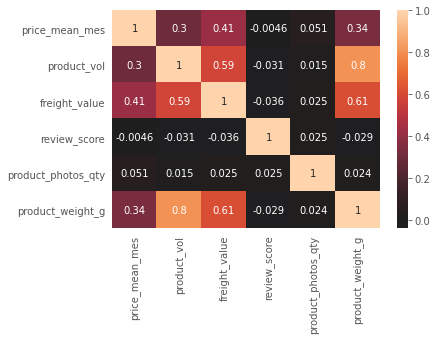

In [190]:
# calculamos la correlacion de las variables
corr =df3[["price_mean_mes",'product_vol','freight_value', 'review_score',"product_photos_qty","product_weight_g"]].corr()
sns.heatmap(corr, center=0, annot=True)

# Conclusion

In this model we group the sales per product by month and with the mean price, and calculate the model whit the variables: **price mean by month, product volume, freight value, review score, product photos quantity, and product weight.**
We can conclude that: 
- R2 represents a simple model
- Any change in the **freight value** represent an expected increment in the mean price in 3.8617 R
- Any change in the **review score** represent an expected increment in the mean price in 1.3446 R
- Any change in the **product photos quantity** represent an expected increment in the mean price in 4.1925 R and 

As a advice for the company we recomend to have more quantity/quality of photos because it represent an increment in the mean price


# Linear regresion Total Sales 

In [194]:
mod5 = smf.ols(formula='total_price~year+freight_value+product_weight_g+product_vol+product_photos_qty+review_score', data=df).fit()
print(mod5.summary())

                            OLS Regression Results                            
Dep. Variable:            total_price   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     6066.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:39:51   Log-Likelihood:            -7.2895e+05
No. Observations:              111709   AIC:                         1.458e+06
Df Residuals:                  111702   BIC:                         1.458e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           7511.6459   1982

# Conclusion

In this model we include all the detail sales and calculate the model whit the variables: **price mean by month, product volume, freight value, review score, product photos quantity, and product weight.**
We can conclude that: 
- R2 represents a simple model
- Any change in the **freight value** represent an expected increment in the mean price in 4.8531 R (the total price is equal to price + freight value)
- Any change in the **review score** represent an expected increment in the mean price in 1.3568 R
- Any change in the **product photos quantity** represent an expected increment in the mean price in 4.3555 R and 

As a advice for the company we recomend to have more quantity/quality of photos because it represent an increment in the mean price


# Total Sales by day

In [45]:
## Data Preprocessing
train_size = int(len(prices) * 0.8)
test_size = len(prices) - train_size
train, test = prices.iloc[0:train_size], prices.iloc[train_size:len(df)]
print(train.shape, test.shape)

(470, 1) (118, 1)


In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['total_price']])

train['total_price'] = scaler.transform(train[['total_price']])
test['total_price'] = scaler.transform(test[['total_price']])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
## Create Training and Test Splits
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [48]:
time_steps = 30

X_train, y_train = create_dataset(train[['total_price']], train.total_price, time_steps)
X_test, y_test = create_dataset(test[['total_price']], test.total_price, time_steps)

print(X_train.shape)

(440, 30, 1)


In [49]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [165]:
## Build an LSTM Autoencoder
model = Sequential([
    
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 30, 128)           131584    
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

In [51]:
## Train the Autoencoder
# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
#     callbacks = [es],
    shuffle=False
)

Epoch 1/100
13/13 [==============================] - 2s 160ms/step - loss: 0.5043 - val_loss: 0.5934
Epoch 2/100
13/13 [==============================] - 1s 86ms/step - loss: 0.3865 - val_loss: 0.6256
Epoch 3/100
13/13 [==============================] - 1s 93ms/step - loss: 0.4135 - val_loss: 0.5836
Epoch 4/100
13/13 [==============================] - 1s 93ms/step - loss: 0.4172 - val_loss: 0.6788
Epoch 5/100
13/13 [==============================] - 1s 89ms/step - loss: 0.3922 - val_loss: 0.5669
Epoch 6/100
13/13 [==============================] - 1s 93ms/step - loss: 0.4078 - val_loss: 0.6440
Epoch 7/100
13/13 [==============================] - 1s 92ms/step - loss: 0.4095 - val_loss: 0.5719
Epoch 8/100
13/13 [==============================] - 1s 87ms/step - loss: 0.3899 - val_loss: 0.6259
Epoch 9/100
13/13 [==============================] - 1s 97ms/step - loss: 0.3874 - val_loss: 0.5691
Epoch 10/100
13/13 [==============================] - 1s 93ms/step - loss: 0.3755 - val_loss: 0.603

Epoch 82/100
13/13 [==============================] - 1s 99ms/step - loss: 0.3061 - val_loss: 0.4122
Epoch 83/100
13/13 [==============================] - 1s 101ms/step - loss: 0.3132 - val_loss: 0.3820
Epoch 84/100
13/13 [==============================] - 1s 101ms/step - loss: 0.3147 - val_loss: 0.4154
Epoch 85/100
13/13 [==============================] - 1s 99ms/step - loss: 0.3078 - val_loss: 0.4032
Epoch 86/100
13/13 [==============================] - 1s 99ms/step - loss: 0.3093 - val_loss: 0.4047
Epoch 87/100
13/13 [==============================] - 1s 110ms/step - loss: 0.3033 - val_loss: 0.3827
Epoch 88/100
13/13 [==============================] - 2s 124ms/step - loss: 0.3073 - val_loss: 0.3944
Epoch 89/100
13/13 [==============================] - 2s 123ms/step - loss: 0.3137 - val_loss: 0.3941
Epoch 90/100
13/13 [==============================] - 2s 134ms/step - loss: 0.3248 - val_loss: 0.4377
Epoch 91/100
13/13 [==============================] - 1s 115ms/step - loss: 0.3177 - 

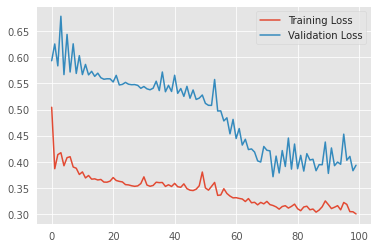

In [52]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [53]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [54]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 14ms/step - loss: 0.3838


0.38376885652542114

# Conclusions

In this model we build a model with Neural Networks to predict the number of sales in a day from the data using a recurrent neural network architecture. 

The model has a loss: 0.3838 this loss function is a measure of the accuracy of the model as it calculates the differences between the true value of the response y and the estimation from the model.

The model did not present overfiting

# Total price vs timeline (by product)

In [157]:
# Calculamos el precio promedio por producto y agregamos la nueva columna
aux=df.groupby('product_id').agg({'price':'mean'}).rename(columns={'price':'price_mean'})
df=pd.merge(df, aux, how="left", left_on="product_id", right_on="product_id")

In [158]:
# Generamos un df con el total de ventas por producto y una lista ordenada de productos en forma descendente
df_PS=df.groupby('product_id').size().to_frame().rename(columns={0:'total_product_sales'}).sort_values('total_product_sales', ascending=False).reset_index()
listaProductos=list(df_PS["product_id"]) #lista ordenada de productos en forma descendente
print("The dataframe has ",len(df['product_id'].unique())," products")

The dataframe has  32952  products


Prices X product:  [ 69.9 109.9  75.   89.9]
['Categorie: moveis_decoracao']


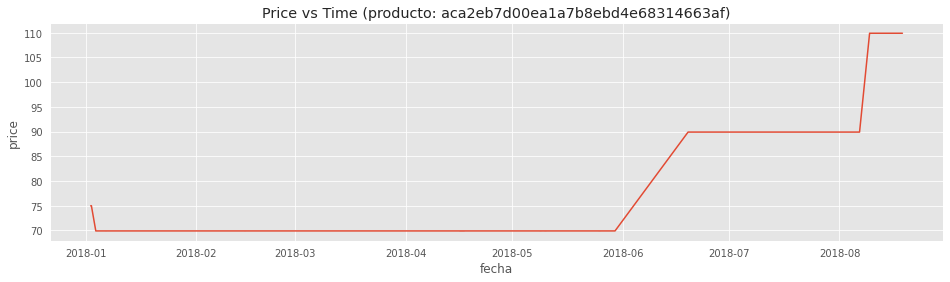

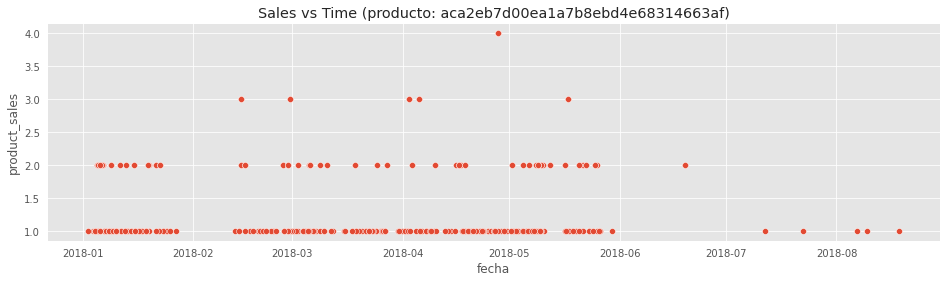

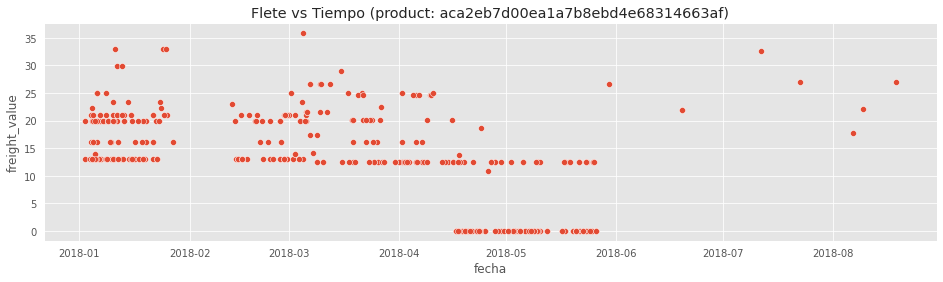

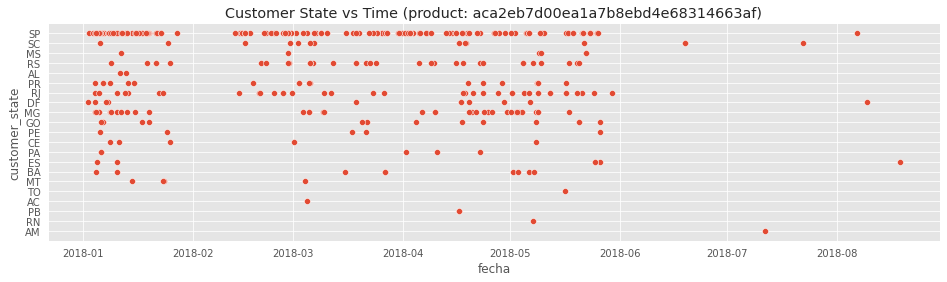

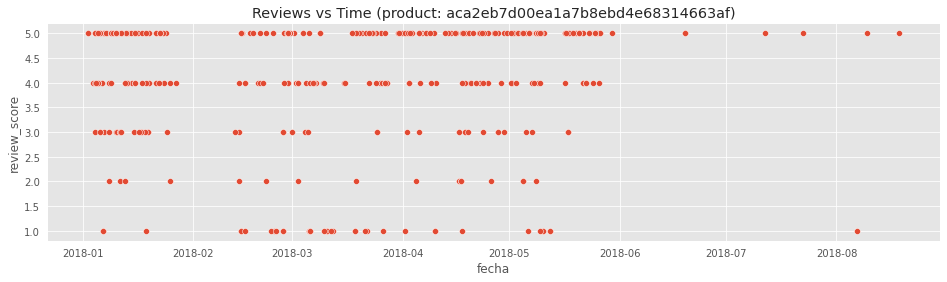

In [161]:
# Realizamos algunas graficas para determinar que variables inlfuyen en el precio del producto
item=0 #numero entre 0 y 32951 para los diferentes productos
m=3   #numero entre 1 y 12 para los diferentes meses
aux=df[(df["product_id"]==listaProductos[item])]
#aux=aux[(aux["mes"]==m)]  #comentar esta linea para graficar todos los meses 
aux=aux[(aux["year"]>2017)]
aux2=aux.groupby(["fecha",'order_id']).size().to_frame().rename(columns={0:'product_sales'}).sort_values('fecha', ascending=True).reset_index()
aux2.drop(['order_id'],axis=1, inplace=True)
aux=pd.merge(aux, aux2, how="left", left_on="fecha", right_on="fecha")

plt.figure(figsize=(16, 4))
ax=sns.lineplot(x='fecha', y='price', data=aux)
# ax=sns.scatterplot(x='fecha', y='price', data=aux)
ax.set_title('Price vs Time (producto: '+listaProductos[item]+')')

plt.figure(figsize=(16, 4))
ax=sns.scatterplot(x='fecha', y='product_sales', data=aux)
ax.set_title('Sales vs Time (producto: '+listaProductos[item]+')')

plt.figure(figsize=(16, 4))
ax=sns.scatterplot(x='fecha', y='freight_value', data=aux)
ax.set_title('Flete vs Tiempo (product: '+listaProductos[item]+')')

plt.figure(figsize=(16, 4))
ax=sns.scatterplot(x='fecha', y='customer_state', data=aux)
ax.set_title('Customer State vs Time (product: '+listaProductos[item]+')')

plt.figure(figsize=(16, 4))
ax=sns.scatterplot(x='fecha', y='review_score', data=aux)
ax.set_title('Reviews vs Time (product: '+listaProductos[item]+')')

print("Prices X product: ",aux.price.unique())
print("Categorie: "+aux.product_category_name.unique())

<AxesSubplot:>

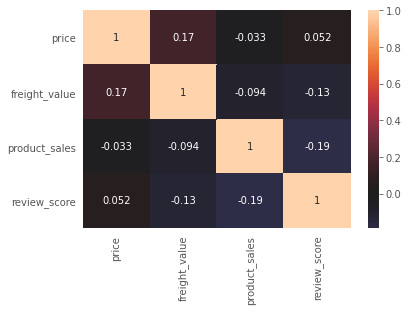

In [74]:
# calculamos la correlacion de las variables
corr =aux[['price','freight_value', 'product_sales','review_score']].corr()
sns.heatmap(corr, center=0, annot=True)

In [109]:
# Intentamos predecir el valor de este producto usando un modelo lineal (modelo 1)
# Definimos la variables independientes y dependientes del modelo 1
y = aux.price
X = aux[['freight_value', 'product_sales','review_score']]
# Dividimos el dataset en entrenamiento y prueba
X_entren, X_prueb, y_entren, y_prueb = train_test_split(X, y, test_size=0.33,random_state=42)

In [110]:
#Entrenamos el modelo 1
modelo = LinearRegression().fit(X_entren, y_entren)

In [111]:
# Datos del modelo 1
print(pd.DataFrame(zip(X_entren.columns, modelo.coef_)))
print('\nintercepto:', modelo.intercept_)
print('r2:', modelo.score(X_prueb,y_prueb))

               0         1
0  freight_value  0.088111
1  product_sales  0.037314
2   review_score  0.238707

intercepto: 68.3515815940163
r2: -0.058518649013417745


In [112]:
# Calculamos el error del modelo 1
pred = modelo.predict(X_prueb)
print('mse', mse(pred, y_prueb))

mse 3.0680065270568466


In [113]:
# Como el error es grande intentamos predecir el valor de este producto usando una red neuronal recurrente
#preprocesamiento de datos
aux=aux[(aux["year"]>2017)]
df2=aux[["fecha","price"]].rename(columns={"fecha":'date'}).rename(columns={"price":'close'})
df2['date'] = pd.to_datetime(df2['date'])
df2=df2.sort_values('date', ascending=True)

train_size = int(len(df2) * 0.8)
test_size = len(df2) - train_size
train, test = df2.iloc[0:train_size], df2.iloc[train_size:len(df2)]
print(train.shape, test.shape)

(330, 2) (83, 2)


In [114]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [115]:
# Dividir el dataset
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30
X_train, y_train = create_dataset(train[['close']], train.close, time_steps)
X_test, y_test = create_dataset(test[['close']], test.close, time_steps)
print(X_train.shape)

(300, 30, 1)


In [116]:
# LSTM Autoencoder
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [117]:
# Definir la arquitectura del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),  #input_shape=(timesteps, num_features)
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

In [118]:
# Entrenar el modelo 
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,  #100
    batch_size=32,
    validation_split=0.1,
    #callbacks = [es],
    shuffle=False
)

Epoch 1/100
9/9 [==============================] - 2s 233ms/step - loss: 0.0316 - val_loss: 0.0110
Epoch 2/100
9/9 [==============================] - 1s 84ms/step - loss: 0.0110 - val_loss: 0.0080
Epoch 3/100
9/9 [==============================] - 1s 89ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 4/100
9/9 [==============================] - 1s 86ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 5/100
9/9 [==============================] - 1s 87ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 6/100
9/9 [==============================] - 1s 85ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 7/100
9/9 [==============================] - 1s 86ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 8/100
9/9 [==============================] - 1s 80ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 9/100
9/9 [==============================] - 1s 89ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 10/100
9/9 [==============================] - 1s 82ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 11/100
9/9 [

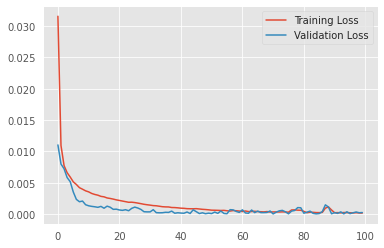

In [119]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [120]:
# Validacion del modelo y calculo de error 
X_train_pred = model.predict(X_train)
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [121]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 14ms/step - loss: 8.5725


8.572541236877441

In [122]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [123]:
test_mae_loss.mean()

0.7051090476999989

# Prediction of reviews beacause punctuality


In [124]:
## Data Preprocessing
df = orders_reviews[['Estimated_Delivered', 'review_score']]
df.rename(columns = {'Estimated_Delivered':'date', 'review_score':'close'}, inplace = True) 
df.columns

/home/jovyan/.local/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Index(['date', 'close'], dtype='object')

In [125]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(80000, 2) (20000, 2)


In [126]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [127]:
## Task 4: Create Training and Test Splits
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [128]:
time_steps = 30

X_train, y_train = create_dataset(train[['close']], train.close, time_steps)
X_test, y_test = create_dataset(test[['close']], test.close, time_steps)

print(X_train.shape)

(79970, 30, 1)


In [130]:
# Build an LSTM Autoencoder
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [131]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(32, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 30, 32)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 32)            8320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 1)             33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
__________________________________________________

In [132]:
## Train the Autoencoder
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
   # callbacks = [es],
    shuffle=False
)

Epoch 1/50
2250/2250 [==============================] - 98s 43ms/step - loss: 0.6982 - val_loss: 0.6871
Epoch 2/50
2250/2250 [==============================] - 96s 43ms/step - loss: 0.6896 - val_loss: 0.6831
Epoch 3/50
2250/2250 [==============================] - 98s 44ms/step - loss: 0.6862 - val_loss: 0.6802
Epoch 4/50
2250/2250 [==============================] - 95s 42ms/step - loss: 0.6845 - val_loss: 0.6798
Epoch 5/50
2250/2250 [==============================] - 98s 43ms/step - loss: 0.6844 - val_loss: 0.6800
Epoch 6/50
2250/2250 [==============================] - 94s 42ms/step - loss: 0.6844 - val_loss: 0.6799
Epoch 7/50
2250/2250 [==============================] - 105s 47ms/step - loss: 0.6844 - val_loss: 0.6798
Epoch 8/50
2250/2250 [==============================] - 104s 46ms/step - loss: 0.6844 - val_loss: 0.6799
Epoch 9/50
2250/2250 [==============================] - 104s 46ms/step - loss: 0.6844 - val_loss: 0.6800
Epoch 10/50
2250/2250 [==============================] - 106s

## Plot Metrics and Evaluate the Model

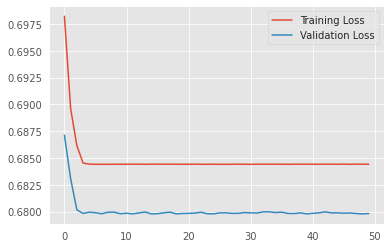

In [137]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [138]:
X_train_pred = model.predict(X_train)
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [139]:
model.evaluate(X_test, y_test)

625/625 [==============================] - 7s 12ms/step - loss: 0.6805


0.680514931678772

/home/jovyan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

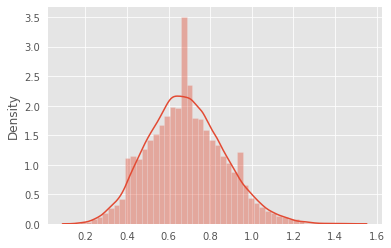

In [140]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [141]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

/home/jovyan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



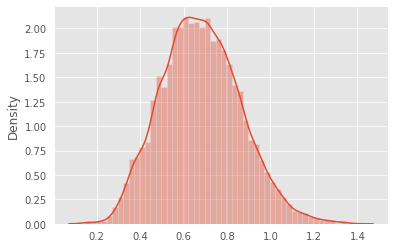

In [142]:
sns.distplot(test_mae_loss, bins=50, kde=True);

# Payment type trends 

In [166]:
efective_orders=orders[(orders.order_status!= 'canceled') & (orders.order_status!= 'unavailable')]

In [167]:
#payment_orders= pd.concat([order_payments,efective_orders], axis=1)
payment_orders=pd.merge(order_payments, efective_orders)

In [168]:
import datetime
timesMonth=[]
timesYear=[]
weekday=[]
hour=[]
for i in payment_orders['order_purchase_timestamp']:
    fecha=pd.to_datetime(i)
    timesMonth.append(fecha.month)
    timesYear.append(fecha.year)
    weekday.append(fecha.dayofweek)
    hour.append(fecha.hour)
payment_orders['Month']=timesMonth
payment_orders['Year']=timesYear
payment_orders['WeekDay']=weekday
payment_orders['Hour']=hour
payment_orders.head()
# pd.datetime.now().year*100+pd.datetime.now().month

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Month,Year,WeekDay,Hour
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22 00:00:00,4,2018,2,22
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16 00:00:00,6,2018,1,11
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04 00:00:00,12,2017,1,11
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04 00:00:00,12,2017,2,12
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,15fd6fb8f8312dbb4674e4518d6fa3b3,delivered,2018-05-21 13:59:17,2018-05-21 16:14:41,2018-05-22 11:46:00,2018-06-01 21:44:53,2018-06-13 00:00:00,5,2018,0,13


#### Most people in Brazil E Commerce use Credit Card  to pay their buys

/home/jovyan/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



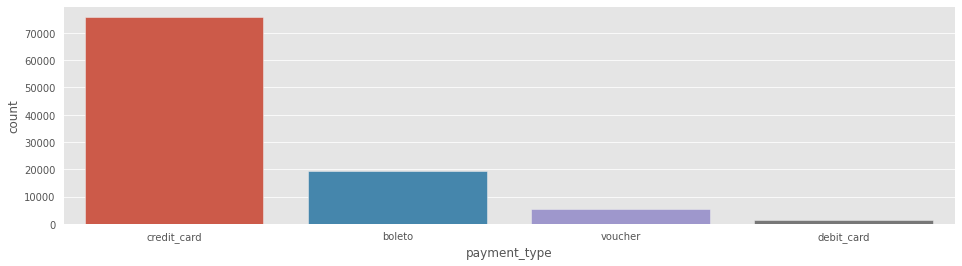

In [169]:
plt.figure(figsize=(16, 4))
sns.countplot('payment_type',data=payment_orders)

plt.show()

#### Sales of best-selling products, show the same behavior as total sales

/home/jovyan/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



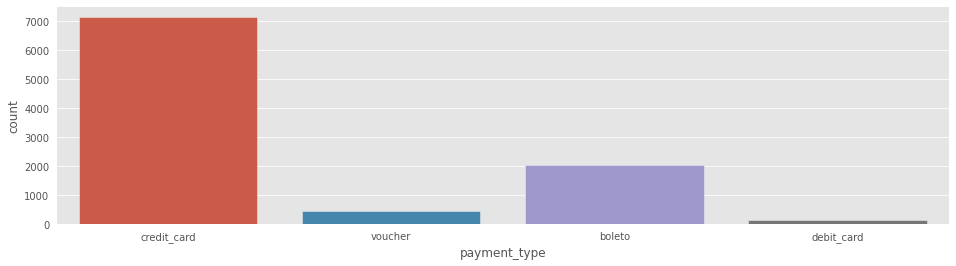

In [170]:
#Sales with more seller products(mor than 100 units per product)
dfrs = order_items.groupby('product_id').count()
dfrs.sort_values(by=['order_id'], ascending=False, inplace=True)
dfrs1 = dfrs[(dfrs['order_id']>100)]
ListProducts=dfrs1.index
ListOrders=order_items[(order_items['product_id'].isin(ListProducts))]['order_id'].unique()
pop=payment_orders[(payment_orders['order_id']).isin(ListOrders)]
plt.figure(figsize=(16, 4))
sns.countplot('payment_type',data=pop)
plt.show()

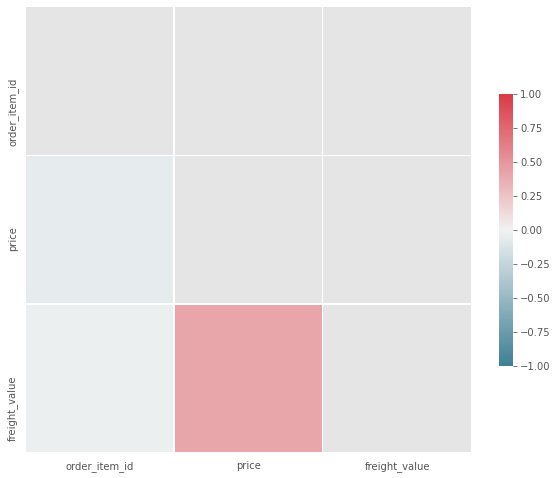

In [171]:
#compute correlation matrix
df_correlations = order_items.corr()
#mask the upper half for visualization purposes
mask = np.zeros_like(df_correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize= (10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,mask=mask,  vmax=1, vmin=-1, cmap=cmap, 
            center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
#orders_by_date

## There is no relevant information in a general line of time related to pay type 

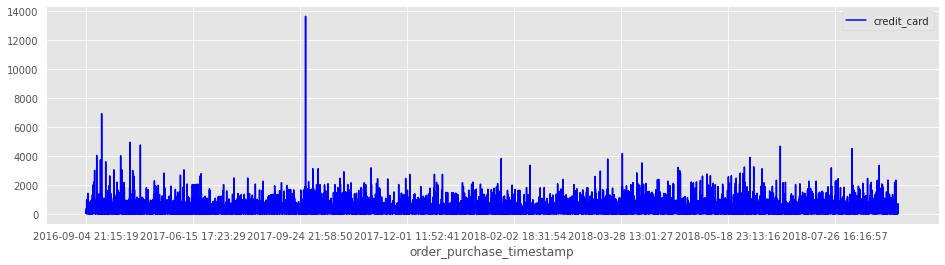

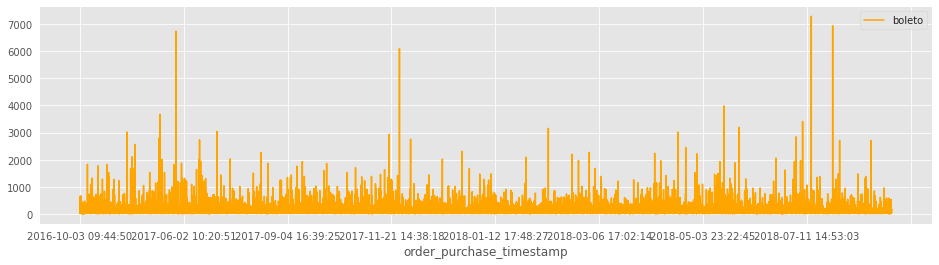

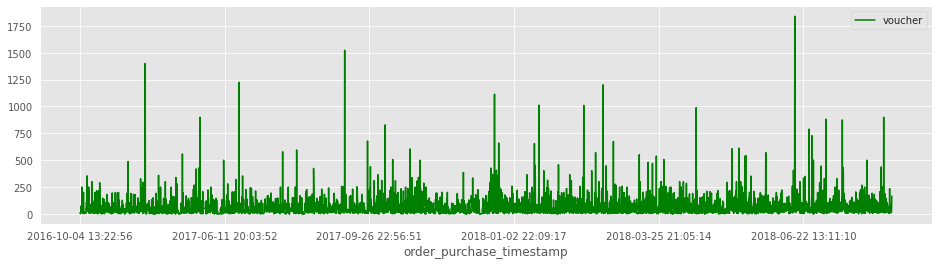

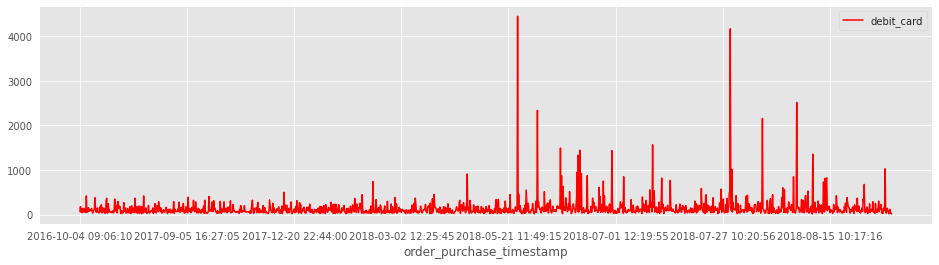

In [172]:
# Comportamiento en el tiempo por Tipo de Pago
payment_orders.sort_values(by=['order_purchase_timestamp'], inplace=True)
listPaymentT = ['credit_card','boleto','voucher','debit_card']
color = ['Blue','Orange','Green','Red']
for i,var in enumerate(listPaymentT):
    #print(var)
    temp = payment_orders[(payment_orders['payment_type'] == var)][['order_purchase_timestamp','payment_value']]
    temp.plot(figsize=(16, 4), kind='line',x='order_purchase_timestamp',y='payment_value', color=color[i] ,label = var)
    plt.tittle = 'Payment Type ' + var
    #plt.xticks(rotation=90)
    #plt.legend()
plt.show()

## In Monthly bases Credit card payment has shown changes in September, payments with boleto show some peak in may, july and november,debit-card is more used in Jun to august

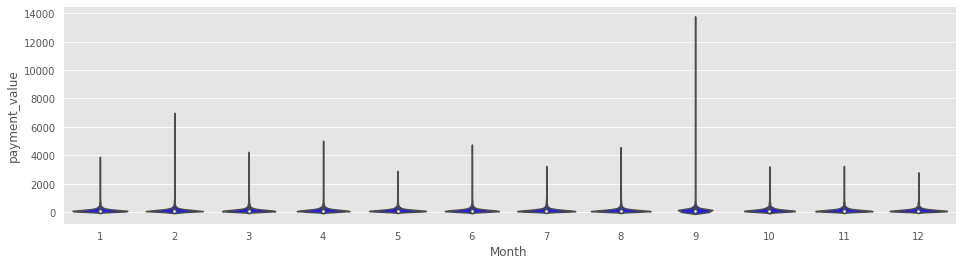

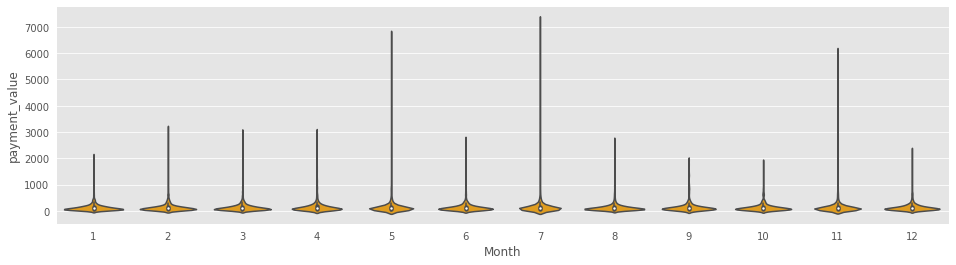

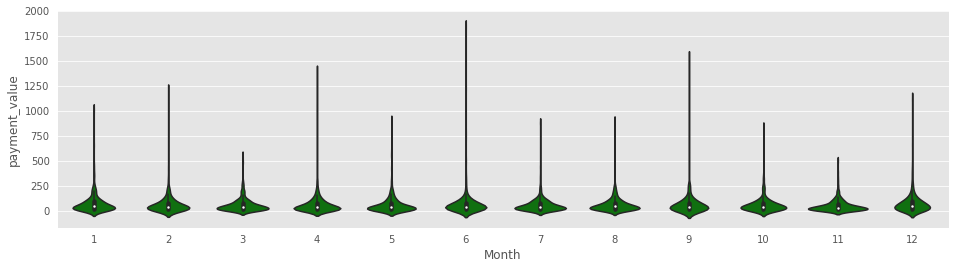

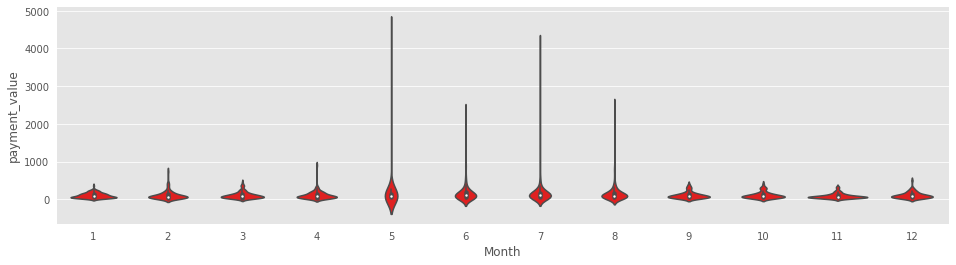

In [173]:
#Behavior Monthly by Payment Type

payment_orders.sort_values(by=['Month'], inplace=True)
listPaymentT = ['credit_card','boleto','voucher','debit_card']
color = ['Blue','Orange','Green','Red']

for i,var in enumerate(listPaymentT):
    plt.figure(figsize=(16, 4))
    #print(var)
    temp = payment_orders[(payment_orders['payment_type'] == var)][['Month','payment_value']]
    #plt.subplot(2,2,i+1)
    sns.violinplot(x='Month',y='payment_value', data=temp ,color=color[i])
    #plt.tittle = 'Payment Type ' + var
    #plt.legend()
    plt.show()

## Thursday and Saturday shows peaks of buyers in credit card, boletos and bouchers are some disperse along week.

credit_card


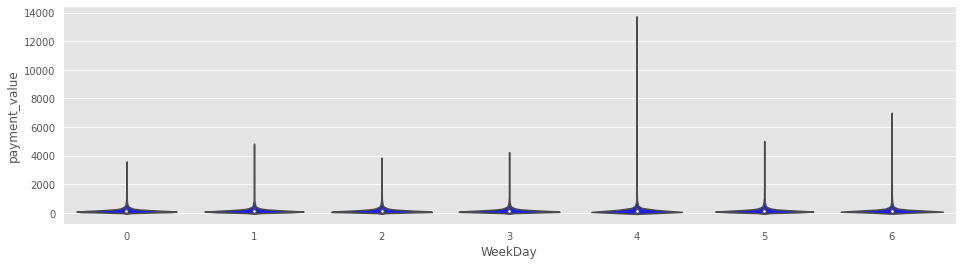

boleto


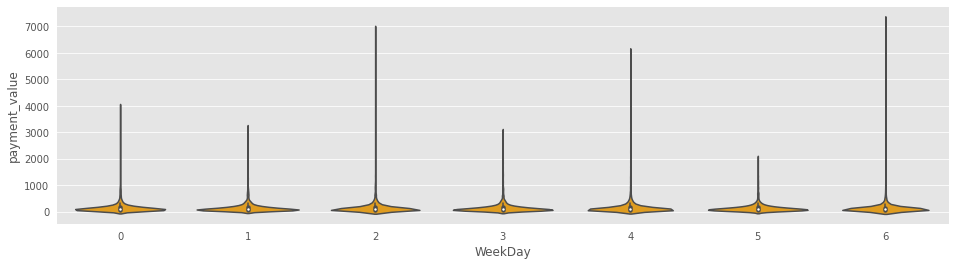

voucher


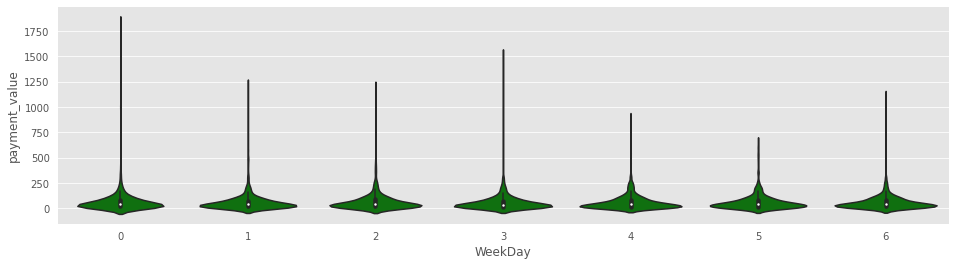

debit_card


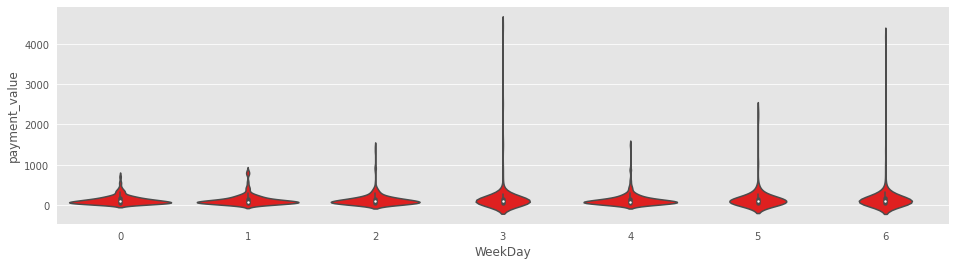

In [174]:
payment_orders.sort_values(by=['WeekDay'], inplace=True)
listPaymentT = ['credit_card','boleto','voucher','debit_card']
color = ['Blue','Orange','Green','Red']

for i,var in enumerate(listPaymentT):
    plt.figure(figsize=(16, 4))
    print(var)
    temp = payment_orders[(payment_orders['payment_type'] == var)][['WeekDay','payment_value']]
    sns.violinplot(x='WeekDay',y='payment_value', data=temp ,color=color[i])
    plt.show()

credit_card


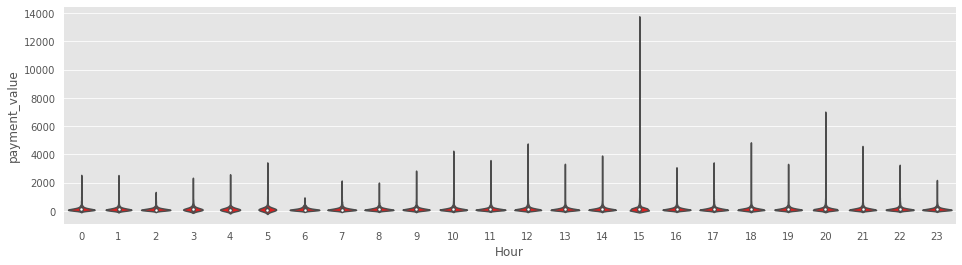

boleto


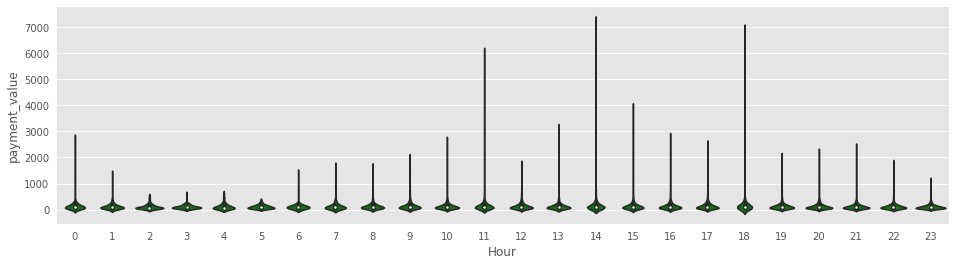

voucher


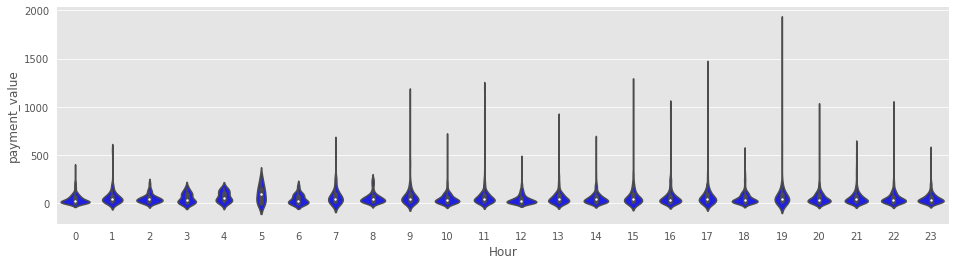

debit_card


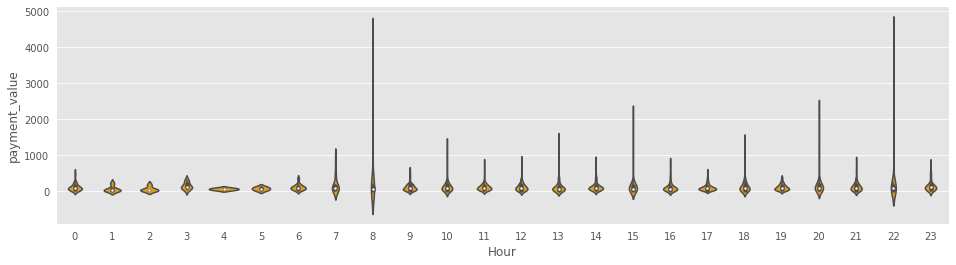

In [175]:
payment_orders.sort_values(by=['Hour'], inplace=True)
listPaymentT = ['credit_card','boleto','voucher','debit_card']
color = ['Red','Green','Blue','Orange']

for i,var in enumerate(listPaymentT):
    print(var)
    plt.figure(figsize=(16, 4))
    temp = payment_orders[(payment_orders['payment_type'] == var)][['Hour','payment_value']]
    sns.violinplot(x='Hour',y='payment_value', data=temp ,color=color[i])
    plt.show()


# Customer purchase trends

## Number of orders x Customer

The idea of this exploration of the data is to understand the number of orders made per customer, in order to understand the volume of purchases made by customers who buy the most.

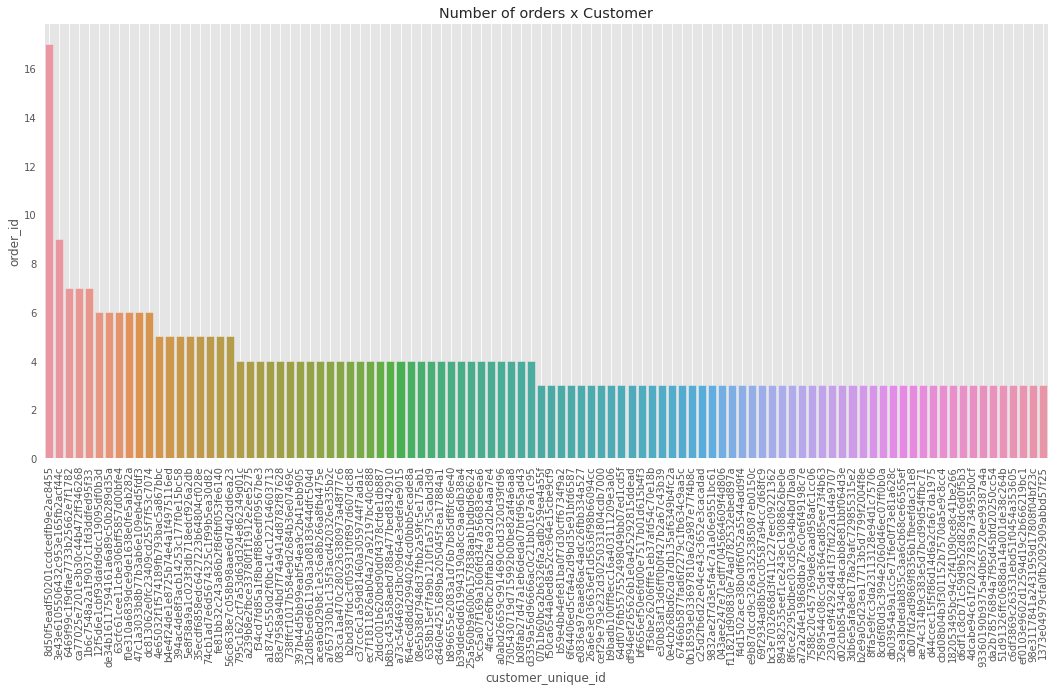

In [176]:
costumer_orders=pd.merge(customer, orders)
aux=costumer_orders.groupby(['customer_unique_id']).agg({'order_id':'count'}).reset_index()
aux=aux.sort_values(by='order_id',ascending=False).head(100)
plt.figure(figsize=(18, 8))
ax=sns.barplot(x='customer_unique_id',y='order_id',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Number of orders x Customer')
ax.grid()

Looking at the top 50 of purchases, they have more than 4  purchases in the period, with a couple of exceptions that they make more.

## Top Payments x customer

Regarding the amount of payments per customer, we can see that the top 50 customers have made purchases in the year for amounts close to US 3000, the average value of total purchases is US 154

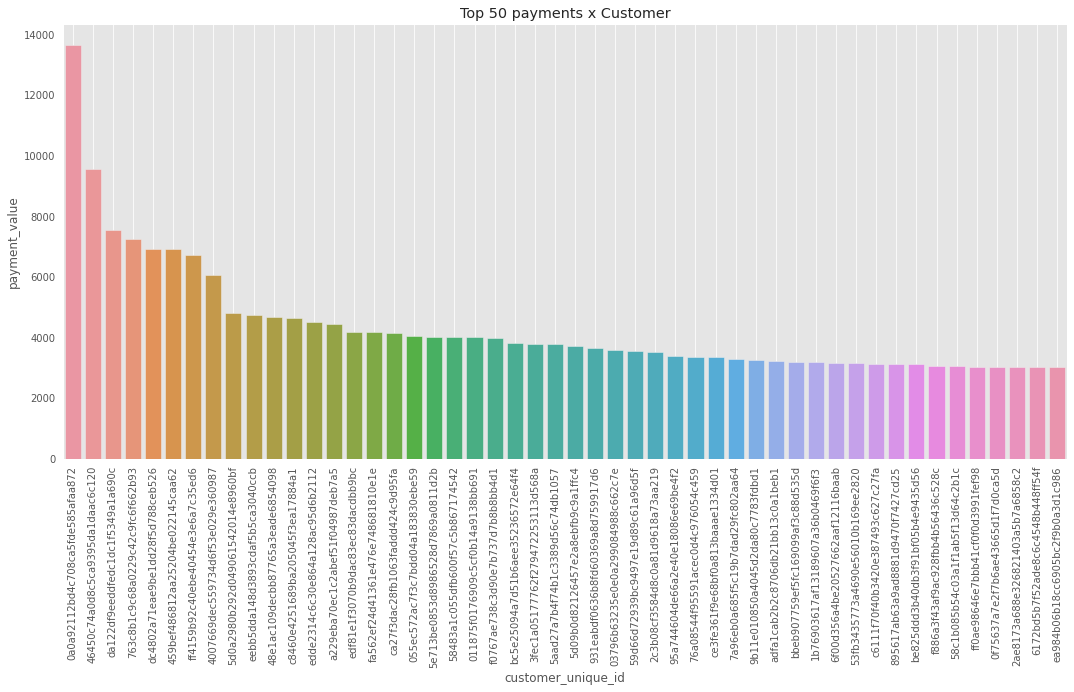

In [177]:
costumer_payments=pd.merge(costumer_orders, order_payments)
aux=costumer_payments.groupby(['customer_unique_id']).agg({'payment_value':'sum'}).reset_index()
aux=aux.sort_values(by='payment_value',ascending=False).head(50)
plt.figure(figsize=(18, 8))
ax=sns.barplot(x='customer_unique_id',y='payment_value',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Top 50 payments x Customer')
ax.grid()
top_customer=aux

In [178]:
costumer_payments.describe()

,customer_zip_code_prefix,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000,103886.000000
mean,35072.550555,1.092679,2.853349,154.100380
std,29743.491677,0.706584,2.687051,217.494064
min,1003.000000,1.000000,0.000000,0.000000
25%,11366.250000,1.000000,1.000000,56.790000
50%,24360.000000,1.000000,1.000000,100.000000
75%,58418.000000,1.000000,4.000000,171.837500
max,99990.000000,29.000000,24.000000,13664.080000


## Prices per product

Regarding the prices for the different product categories, we find that the most expensive products are related to the categories of Household utilities, Computers, Arts and electrical appliances. Within these, the highest price range refers to computers

<AxesSubplot:xlabel='price', ylabel='product_category_name'>

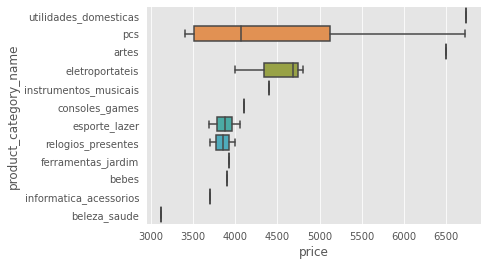

In [179]:
order_product=pd.merge(products, order_items)
top_products= order_product.sort_values(['price'],ascending=False).head(20)
sns.boxplot(y=top_products['product_category_name'], x=top_products["price"])


## Top Products sold

Regarding the best-selling products, the following categories have the highest amount of sales:

|Product Category   |Number of purchases |
|---|---|
|Cama_mesa_banho |11.823 |
|beleza_saude |9.972|
|esporte_lazer | 8.945|
|moveis_decoracao |8744| 
|informatica_acessorios |8082|
|utilidades_domesticas |7355|

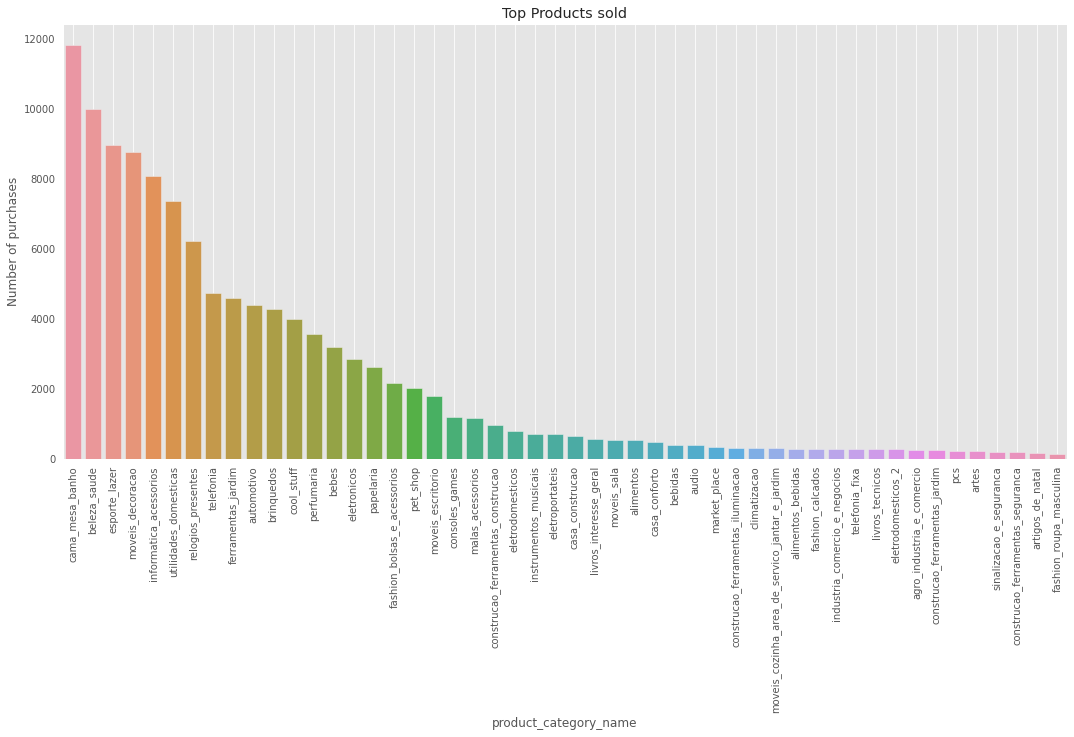

In [180]:
client_product=pd.merge(costumer_payments, order_product)
aux=client_product.groupby('product_category_name').size().to_frame().rename(columns={0:'Number of purchases'}).reset_index()
aux=aux.sort_values(by='Number of purchases',ascending=False).head(50)
plt.figure(figsize=(18, 8))
ax=sns.barplot(x='product_category_name',y='Number of purchases',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Top Products sold')
ax.grid()

## MODEL DEFINITION

In [ ]:
Cus_ord_itm = pd.merge(left = df , right = order_items , how='left', left_on='order_id', right_on='order_id')
Cus_ord_itm.head() 

In [ ]:
timesMonth=[]
timesYear=[]
weekday=[]
hour=[]
for i in Cus_ord_itm['order_purchase_timestamp']:
    fecha=pd.to_datetime(i)
    timesMonth.append(fecha.month)
    timesYear.append(fecha.year)
    weekday.append(fecha.dayofweek)
    hour.append(fecha.hour)
Cus_ord_itm['Month']=timesMonth
Cus_ord_itm['Year']=timesYear
Cus_ord_itm['WeekDay']=weekday
Cus_ord_itm['Hour']=hour
Cus_ord_itm['YearMonth']=Cus_ord_itm['Year']*100+Cus_ord_itm['Month']
Cus_ord_itm.head()

In [ ]:
#compute correlation matrix
df_correlations = Cus_ord_itm.corr()
#mask the upper half for visualization purposes
mask = np.zeros_like(df_correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize= (10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,mask=mask,  vmax=1, vmin=-1, cmap=cmap, 
            center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
#orders_by_date

In [ ]:
mod1 = smf.ols(formula='total_price~regions', data=Cus_ord_itm).fit()
print(mod1.summary())

In [ ]:
mod3 = smf.ols(formula='total_price~regions+product_category_name', data=Cus_ord_itm).fit()
print(mod3.summary())

In [ ]:
mod4 = smf.ols(formula='price~Year+Month', data=Cus_ord_itm).fit()
print(mod4.summary())

In [ ]:
'''
customer = pd.read_csv(ruta+'olist_customers_dataset.csv', delimiter=',') 
order_items=pd.read_csv(ruta+'olist_order_items_dataset.csv', delimiter=',') 
orders=pd.read_csv(ruta+'olist_orders_dataset.csv', delimiter=',') 
products=pd.read_csv(ruta+'olist_products_dataset.csv', delimiter=',') 
order_payments=pd.read_csv(ruta+'olist_order_payments_dataset.csv', delimiter=',')
reviews=pd.read_csv(ruta+'olist_order_reviews_dataset.csv', delimiter=',')
order_items=pd.read_csv(ruta+'olist_order_items_dataset.csv', delimiter=',')
sellers=pd.read_csv(ruta+'olist_sellers_dataset.csv', delimiter=',') 
'''


In [ ]:
#Merge
#df=pd.merge(df1, df2, how="left", left_on="customer_id", right_on="customer_id")
merged_df=pd.merge(order_payments, orders, how='left', left_on='order_id', right_on='order_id')
merged_df=pd.merge(merged_df, reviews, how='left', left_on='order_id', right_on='order_id')
merged_df=pd.merge(merged_df, customer, how='left', left_on='customer_id', right_on='customer_id')
merged_df=pd.merge(merged_df, order_items, how='left', left_on='order_id', right_on='order_id')
merged_df=pd.merge(merged_df, products, how='left', left_on='product_id', right_on='product_id')
merged_df=pd.merge(merged_df, sellers, how='left', left_on='seller_id', right_on='seller_id')
merged_df=pd.merge(merged_df, sellers, how='left', left_on='seller_id', right_on='seller_id')
merged_df.head()

In [ ]:
merged_df.describe()

In [ ]:
#Data['pay'] = Data['income'] + Data['bonus']
merged_df['total_pay'] = merged_df['price']+merged_df['freight_value']
merged_df.head()

In [ ]:
plt.scatter(merged_df['review_score'],merged_df['payment_value'])
plt.title("payment_value vs review_score", fontsize=18, verticalalignment='bottom')
plt.xlabel("review_score")
plt.ylabel("payment_value");

In [ ]:
sns.boxplot(x='review_score', y='payment_value', data = merged_df)
plt.title('review_score vs payment_value')

In [ ]:
corr_mat  = merged_df.corr()
corr_mat

In [ ]:
sns.heatmap(corr_mat,cmap=sns.diverging_palette(500, 20, as_cmap=True))
plt.title("Correlation Matrix")

In [ ]:
plt.scatter(merged_df['payment_installments'],merged_df['payment_value'])
plt.title("payment_value vs payment_installments", fontsize=18, verticalalignment='bottom')
plt.xlabel("payment_installments")
plt.ylabel("payment_value");

In [ ]:
merged_df['customer_id'].unique()

# Regiones Cristian

In [ ]:
merged_df.columns

In [ ]:
estados= {'AC':'Acre', 'AL':'Alagoas', 'AM':'Amazonas', 'AP':'Amapá', 'BA':'Bahía', 'CE':'Ceará',
          'DF':'Distrito Federal', 'ES':'Espírito Santo', 'GO':'Goiás', 'MA':'Maranhão', 'MG':'Minas Gerais',
          'MS':'Mato Grosso del Sur', 'MT':'Mato Grosso', 'PA':'Pará', 'PB':'Paraíba', 'PE':'Pernambuco',
          'PI':'Piauí', 'PR':'Paraná', 'RJ':'Río de Janeiro', 'RN':'Río Grande del Norte', 'RO':'Rondonia',
          'RR':'Roraima', 'RS':'Río Grande del Sur', 'SC':'Santa Catarina', 'SE':'Sergipe', 'SP':'São Paulo', 'TO':'Tocantins'}
merged_df['name_state'] = merged_df['customer_state']
for i in range(len(estados)):
    merged_df["name_state"]=merged_df["name_state"].str.replace(list(estados.keys())[i],list(estados.values())[i])
merged_df['name_state'].head()

In [ ]:
region = ["Norte","Sur","Sudeste","Nordeste","CentroOeste"]
regiones= {'AC':'Norte', 'AL':'Nordeste', 'AM':'Norte', 'AP':'Norte', 'BA':'Nordeste',
           'CE':'Nordeste', 'DF':'CentroOeste', 'ES':'Sudeste', 'GO':'CentroOeste',
           'MA':'Nordeste', 'MG':'Sudeste', 'MS':'CentroOeste', 'MT':'CentroOeste',
           'PA':'Norte', 'PB':'Nordeste', 'PE':'Nordeste', 'PI':'Nordeste', 'PR':'Sur',
           'RJ':'Sudeste', 'RN':'Nordeste', 'RO':'Norte', 'RR':'Norte', 'RS':'Sur',
           'SC':'Sur', 'SE':'Nordeste', 'SP':'Sudeste', 'TO':'Norte'}
merged_df['regions']=merged_df['customer_state']
for i in range(len(estados)):
    merged_df["regions"]=merged_df["regions"].str.replace(list(regiones.keys())[i],list(regiones.values())[i])

merged_df['regions'].head()

In [ ]:
merged_df['ano_mes']=merged_df['order_purchase_timestamp'].str.split('-', expand=True)[0]+"-"+merged_df['order_purchase_timestamp'].str.split('-', expand=True)[1]
merged_df['ano_mes_dt'] = pd.to_datetime(merged_df['ano_mes'])
merged_df['fecha'] = pd.to_datetime(merged_df['order_purchase_timestamp'])
merged_df['Year']= merged_df['fecha'].dt.year
merged_df['mes']= merged_df['fecha'].dt.month
merged_df.ano_mes = merged_df.ano_mes.astype('category')
merged_df['codes']= merged_df.ano_mes.cat.codes

In [ ]:
Regional_Estimation = merged_df[['regions', 'total_pay', 'Year', 'mes']]
Regional_Estimation.head(10)

In [ ]:
Regional_Estimation1 = Regional_Estimation.groupby(['regions', 'Year', 'mes']).agg({'total_pay': ['sum']})   
Regional_Estimation1 = Regional_Estimation1.reset_index()
Regional_Estimation1

In [ ]:
Regional_Estimation1['mes'] = Regional_Estimation1.mes.map("{:02}".format)

In [ ]:
Regional_Estimation1['Year_Month'] = (Regional_Estimation1['Year'].astype(str) + '/' + Regional_Estimation1['mes'].astype(str))
Regional_Estimation1['Complete_Date'] = pd.to_datetime(Regional_Estimation1['Year_Month'])
Regional_Estimation1

In [ ]:
g = sns.FacetGrid(Regional_Estimation1, col="regions")
g.map(sns.barplot,'Year_Month','total_pay');

In [ ]:
formula = 'total_pay~Year_Month'
model   = sfm.ols(formula = formula, data = Regional_Estimation1).fit()
print(model.summary())

In [ ]:
Estimation_CentroOeste = Regional_Estimation1[Regional_Estimation1.regions == "CentroOeste"]
Estimation_CentroOeste = Estimation_CentroOeste[['Year_Month', 'total_pay']]
Estimation_CentroOeste.head()

In [ ]:
formula = 'total_pay~Year_Month'
model   = sfm.ols(formula = formula, data = Estimation_CentroOeste).fit()
print(model.summary())